### Installing Packages

In [200]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [201]:
pip install sodapy

Note: you may need to restart the kernel to use updated packages.


In [202]:
pip install tabula-py

Note: you may need to restart the kernel to use updated packages.


In [1018]:
pip install git+https://github.com/pdftables/python-pdftables-api.git

  Cloning https://github.com/pdftables/python-pdftables-api.git to /private/var/folders/5w/82q2gcks59d3npvwjk0xmsm80000gn/T/pip-req-build-fkrb6u41
  Running command git clone --filter=blob:none --quiet https://github.com/pdftables/python-pdftables-api.git /private/var/folders/5w/82q2gcks59d3npvwjk0xmsm80000gn/T/pip-req-build-fkrb6u41
  Resolved https://github.com/pdftables/python-pdftables-api.git to commit 0abf88cc499ed6c001fb641791f84cdc8eafbc58
  Preparing metadata (setup.py) ... done
  Created wheel for pdftables-api: filename=pdftables_api-2.0.0-py3-none-any.whl size=5857 sha256=d266e7706a86e18cf05de028e868bf3c348d32be8fa7e616026b06dfb9508168
  Stored in directory: /private/var/folders/5w/82q2gcks59d3npvwjk0xmsm80000gn/T/pip-ephem-wheel-cache-huwibknc/wheels/08/f9/61/03de7463e2d9a990f0ee3865faf7286ad320d0a0095bb99cc9
Successfully built pdftables-api
Note: you may need to restart the kernel to use updated packages.


In [1019]:
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.collections
import geopandas as gpd
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon, LineString, MultiLineString
from shapely import wkt
from shapely.ops import linemerge, unary_union, polygonize
import shapely as shp
# from shapely.errors import NotImplementedError
import requests
import io
import urllib.parse
import geopy
from time import sleep
from random import randint
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
from sodapy import Socrata
import tabula
import pdftables_api

### Defining Methods Here

In [596]:
def random_points_within(poly, num_points, axis=0):
    min_x, min_y, max_x, max_y = poly.bounds

    points = []
    test = []

    while len(test) < num_points:
        rand_x = random.uniform(min_x, max_x)
        rand_y = random.uniform(min_y, max_y)
        random_point = Point([rand_x, rand_y])
        if (random_point.within(poly)):
            test.append((rand_x, rand_y))
    
    test = sorted(test, key=lambda x: x[axis])
    
    for i in range(len(test)):
        points.append(Point(test[i]))
        
    return MultiPoint(points)

In [598]:
def split_points(poly, pop, random_points, num_polys):

    min_x, min_y, max_x, max_y = poly.bounds
    
    slices = []
    point_chunks = []
    
    for i in range(num_polys):   
        start = int(i*pop/num_polys)
        end = int((i+1)*pop/num_polys)
        random_points_slice = random_points.geoms[start:end]
        point_chunks.append(random_points_slice)
        
        slice_min_x, slice_min_y, slice_max_x, slice_max_y = random_points_slice.bounds
        slices.append(slice_max_y)
    
    return point_chunks, slices

In [805]:
def split_polygon(poly, slices, points_chunks):
    if len(slices)==1 or 0:
        return poly
    min_x, min_y, max_x, max_y = poly.bounds
    polygon_list = []
    
    
    for i in range(len(slices)):
        y = slices[i]
        line = LineString([(min_x, y),(max_x, y)])
        try:
            merged = linemerge([poly.boundary, line])
        except Exception as e:
            merged = linemerge([poly.boundary.geoms[0], line])
#             print("Poly geoms")
#             print(list(poly.boundary.geoms))
#             print("Poly boundary")
#             print(poly.boundary)
# #             print("Poly geoms")
# #             print(list(poly.geoms))
# #             plt.plot(poly.boundary)
#             print("Line")
#             print(line)
#             print("Linemerge")
#             print(linemerge([poly.boundary.geoms,line]))
        borders = unary_union(merged)

        polygons = polygonize(borders)
        num_segments = len(list(polygons))
        polygons = polygonize(borders)

        j = 0
        to_append = []
        for p in polygons:
            if j==0:
                to_append.append(p)
                if num_segments==2:
                    polygon_list.append(to_append)
            elif j==1:
                poly = p
            elif j>1 and j==(num_segments-1):
                to_append.append(p)
                polygon_list.append(to_append)
            j=j+1
            
    
    for k in range(len(polygon_list)):
        for j in range(len(polygon_list[k])): 
            test = False
            for i in range(len(points_chunks[k].geoms)):
                if polygon_list[k][j].contains(points_chunks[k].geoms[i]):
                    test = True

            if test==False:
                polygon_list[k].remove(polygon_list[k][j])
    
    return polygon_list

In [1137]:
def display_poly_split(poly, polys, num_polys, df, random_points, points_chunks, index):
    fig, ax = plt.subplots(1,num_polys+1, figsize=(12,8))
    min_x, min_y, max_x, max_y = poly.bounds
    
    stations = df[df['Census Tract'] == df.iloc[index]['Census Tract']]
    
    for i in range(stations.shape[0]):
        lat = float(stations.iloc[i]['lat'])
        lon = float(stations.iloc[i]['lon'])
        ax[0].plot(lon, lat, 'r*')
        x,y = poly.centroid.xy
        ax[0].plot(x[0], y[0], 'y*')
        ax[0].plot([lon, x[0]], [lat, y[0]], color='r')

    for i in range(len(random_points.geoms)):
        x,y = random_points.geoms[i].xy
        ax[0].plot(x,y,'g.', alpha=0.5, markersize=5)
        x1, y1 = poly.exterior.xy
        ax[0].plot(x1,y1,'black', linewidth=0.2)
    
    for i in range(num_polys):
        random_points_slice = points_chunks[i]
        for j in range(len(random_points_slice.geoms)):
            x,y = random_points_slice.geoms[j].xy
            ax[i+1].plot(x,y,'g.', alpha=0.5, markersize=5)
        if isinstance(polys[i], list):
            for k in range(len(polys[i])):
                # Plotting each sub-polygon exterior
                x,y = polys[i][k].exterior.xy
                ax[i+1].plot(x,y,'black', linewidth=0.2)
        else:
            x,y = polys[i].exterior.xy
            ax[i+1].plot(x,y,'black', linewidth=0.2) 

        # Plotting actual polling location
        for l in range(stations.shape[0]):
            lat = float(stations.iloc[l]['lat'])
            lon = float(stations.iloc[l]['lon'])
            ax[i+1].plot(lon, lat, 'r*')
#             for j in range(len(polys[i])):
            if isinstance(polys[i], list):
                for m in range(len(polys[i])):
                    c_x,c_y = polys[i][m].centroid.xy
                    ax[i+1].plot(c_x,c_y,'y*')
                    ax[i+1].plot([lon, c_x[0]], [lat, c_y[0]], color='r')
            else:
                c_x,c_y = polys[i].centroid.xy
                ax[i+1].plot(c_x,c_y,'y*')
                ax[i+1].plot([lon, c_x[0]], [lat, c_y[0]], color='r')


    for i in range(len(ax)):
        ax[i].set_xlim(min_x, max_x)
        ax[i].set_ylim(min_y, max_y)
    
    
    title = df.iloc[index]['Census Tract']
    fig.suptitle(title)
    fig.supxlabel("Longitude")
    fig.supylabel("Latitude")
    
    plt.tight_layout()
    path = '/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/final_project/Polling_Locations/{}.png'.format(title)
    plt.savefig(path)
    ;


In [389]:
def radians_to_km(value, lat):
    return 111.11 * np.cos(lat/180*np.pi) * value

In [390]:
def calculate_distance(x_1, y_1, x_2, y_2):
    return np.sqrt((x_2-x_1)**2+(y_2-y_1)**2)

In [391]:
def compare_poll_to_centroid(poly, random_points, lat, lon):
    distances_cent = np.zeros(len(random_points.geoms))
    distances_poll = np.zeros(len(random_points.geoms))
    
    if isinstance(poly,list):
        if len(poly)==1:
            poly = poly[0]
        elif len(poly)>1:
            for j in range(len(poly)):
                curr_poly = poly[j]
                x_cent, y_cent = curr_poly.centroid.xy

                for i in range(len(random_points.geoms)):
                    x, y = random_points.geoms[i].xy
                    dist_to_centroid = calculate_distance(x[0], y[0], x_cent[0], y_cent[0])
                    distances_cent[i] = dist_to_centroid
                    dist_to_poll = calculate_distance(x[0], y[0], lon, lat)
                    distances_poll[i] = dist_to_poll
            return sum(distances_poll) - sum(distances_cent)
            
            
    x_cent, y_cent = poly.centroid.xy

    for i in range(len(random_points.geoms)):
        x, y = random_points.geoms[i].xy
        dist_to_centroid = calculate_distance(x[0], y[0], x_cent[0], y_cent[0])
        distances_cent[i] = dist_to_centroid
        dist_to_poll = calculate_distance(x[0], y[0], lon, lat)
        distances_poll[i] = dist_to_poll

    # This currently returns distance in degrees, not KM or miles (I think - should be sum degrees across rand points)
    return sum(distances_poll) - sum(distances_cent)

In [392]:
def calculate_distance_to_poll(poly, pop, num_stations, lat, lon, df, tract):
    """
    Inputs: poly - polygon representing census tract of interest
    num_stations - the number of polling stations to model in the census tract
    lat, lon - arrays of the lat/lon locations of polling locations in the census tract
    df - Pandas Dataframe containing information on census tracts, polling locations, and demographic data
    tract - census tract we're currently evaluating
    """
    
    # Define random set of points to model population within census tract
    random_points = random_points_within(poly, pop, 1)
    total_distance = 0
    if num_stations==1:
        lat = float(lat[0])
        lon = float(lon[0])
        total_distance = compare_poll_to_centroid(poly, random_points, lat, lon)
        return total_distance
    elif num_stations>1:
        points_chunks, slices = split_points(poly, pop, random_points, num_stations)
        polys = split_polygon(poly, slices, points_chunks)
        for i in range(len(polys)):
            distance = compare_poll_to_centroid(polys[i], points_chunks[i], float(lat[i]), float(lon[i]))
            total_distance = total_distance + distance
        return total_distance
    elif num_stations==0:
        # Find closest polling station to centroid
#         lon_c, lat_c = df.iloc[1]['geometry'].centroid.xy
        lon_c, lat_c = poly.centroid.xy
        lat_c = lat_c[0]
        lon_c = lon_c[0]
        search_df = df[df['Polling Station Count']>0]
        min_distance = np.inf
        index = np.inf
        for i in range(search_df.shape[0]):
            lat_stat = float(search_df.iloc[i]['lat'])
            lon_stat = float(search_df.iloc[i]['lon'])
            distance = calculate_distance(lon_c, lat_c, lon_stat, lat_stat)
            if distance < min_distance:
                min_distance = distance
                index = search_df.iloc[i].name
        
        # Then, I need to go through the above steps again
        lat = float(df.iloc[index]['lat'])
        lon = float(df.iloc[index]['lon'])
        total_distance = compare_poll_to_centroid(poly, random_points, lat, lon)
        return total_distance

### Downloading Data

2016 Fulton County

In [894]:
# Downloading 2016 Fulton County polling location information
url = 'https://raw.githubusercontent.com/PublicI/us-polling-places/update-2020/data/georgia/output/Georgia_2016-11-08.csv'
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [895]:
# Converting Fulton County polling location addresses to lat/lon coordinates
fulton_2016 = df[df['county_name']=='FULTON'].copy()
locator = Nominatim(user_agent='myGeocoder')
fulton_2016['Location'] = fulton_2016['address'].apply(lambda x: locator.geocode(x))
fulton_2016['Location'] = fulton_2016['Location'].fillna('None')
fulton_2016['lat'] = fulton_2016['Location'].apply(lambda x: x.latitude if x!='None' else "None")
fulton_2016['lon'] = fulton_2016['Location'].apply(lambda x: x.longitude if x!='None' else "None")

In [976]:
# Creating a data frame with just the lat/lon coordinates for fulton county
coords_2016 = fulton_2016[fulton_2016['lat']!='null'].drop_duplicates(['lat', 'lon'])[['lat', 'lon']]
coords_2016 = coords_2016[coords_2016['lat']!='None']
coords_2016['lat'] = coords_2016['lat'].astype(float)
coords_2016['lon'] = coords_2016['lon'].astype(float)

In [977]:
coords_2016

lat        lon
1191  33.736205 -84.422354
1192  33.754829 -84.513820
1194  33.771529 -84.387836
1200  33.725739 -84.391395
1203  33.690414 -84.511569
...         ...        ...
1537  33.556432 -84.522744
1544  33.705693 -84.461678
1546  34.073881 -84.292229
1547  33.731003 -84.441772
1549  33.729584 -84.392532

[138 rows x 2 columns]

2018 Fulton County

In [172]:
# Downloading 2018 Fulton County polling location information
url = 'https://raw.githubusercontent.com/PublicI/us-polling-places/update-2020/data/georgia/output/Georgia_2018-11-06.csv'
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [184]:
# Converting Fulton County polling location addresses to lat/lon coordinates
fulton_2018 = df[df['county_name']=='FULTON'].copy()
locator = Nominatim(user_agent='myGeocoder')
fulton_2018['Location'] = fulton_2018['address'].apply(lambda x: locator.geocode(x))
fulton_2018['Location'] = fulton_2018['Location'].fillna('None')
fulton_2018['lat'] = fulton_2018['Location'].apply(lambda x: x.latitude if x!='None' else "None")
fulton_2018['lon'] = fulton_2018['Location'].apply(lambda x: x.longitude if x!='None' else "None")

In [943]:
# Creating a data frame with just the lat/lon coordinates for fulton county
coords_2018 = fulton_2018[fulton_2018['lat']!='null'].drop_duplicates(['lat', 'lon'])[['lat', 'lon']]
coords_2018 = coords_2018[coords_2018['lat']!='None']
coords_2018['lat'] = coords_2018['lat'].astype(float)
coords_2018['lon'] = coords_2018['lon'].astype(float)

##### 2020 Fulton County

In [4]:
# Downloading 2020 Fulton County polling location information
url = 'https://raw.githubusercontent.com/PublicI/us-polling-places/update-2020/data/georgia/output/Georgia_2020-11-03.csv'
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [5]:
# I THINK I CAN DELETE THIS
# Converting Fulton County polling location addresses to lat/lon coordinates
address = df['address'][0]
url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
response = requests.get(url).json()
lat = response[0]["lat"]
lon = response[0]["lon"]

In [6]:
# Converting Fulton County polling location addresses to lat/lon coordinates
fulton = df[df['county_name']=='Fulton'].copy()
locator = Nominatim(user_agent='myGeocoder')
fulton['Location'] = fulton['address'].apply(lambda x: locator.geocode(x))
fulton['Location'] = fulton['Location'].fillna('None')
fulton['lat'] = fulton['Location'].apply(lambda x: x.latitude if x!='None' else "None")
fulton['lon'] = fulton['Location'].apply(lambda x: x.longitude if x!='None' else "None")

##### 2022 Fulton County

In [1021]:
# Converting from PDF to CSV

# API KEY VERIFICATION
api_key = '71kr3af69mle'
conversion = pdftables_api.Client(api_key)

# PDF to CSV
pdf_file_path = '/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/final_project/Polling_Locations/Fulton_2022_locations.pdf'
output_file_path = '/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/final_project/Polling_Locations/Fulton_2022_locations.csv'
conversion.csv(pdf_file_path, output_file_path)

In [1076]:
# Did geocoding in another notebook, reading in already geocoded data
input_file_path = '/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/final_project/Polling_Locations/fulton_2022.csv'
df = pd.read_csv(input_file_path)
df = df.drop('Unnamed: 0', axis=1)

In [1086]:
coords_2022 = df.drop_duplicates(['lat', 'lon'])[['lat', 'lon']]
coords_2022['lat'] = coords_2022['lat'].astype(float)
coords_2022['lon'] = coords_2022['lon'].astype(float)

#### Pulled Georgia counties polling place data for 2020 from another notebook

In [440]:
# Converting Georgia polling location addresses to lat/lon coordinates
# locator = Nominatim(user_agent='myGeocoder')
# geocode = RateLimiter(locator.geocode, min_delay_seconds=2)

# georgia_coords['Location'] = df['address'].apply(geocode).apply(lambda location: (location.latitude, location.longitude))
# # georgia_coords['Location'] = df['address'].apply(lambda x: locator.geocode(x))
# georgia_coords['Location'] = georgia_coords['Location'].georgia_coords('None')
# georgia_coords['lat'] = georgia_coords['Location'].apply(lambda x: x.latitude if x!='None' else "None")
# georgia_coords['lon'] = georgia_coords['Location'].apply(lambda x: x.longitude if x!='None' else "None")
# georgia_coords = georgia_coords[georgia_coords['lat']!='null'].drop_duplicates(['lat', 'lon'])[['lat', 'lon']]
# georgia_coords = georgia_coords[georgia_coords['lat']!='None']
# georgia_coords['lat'] = georgia_coords['lat'].astype(float)
# georgia_coords['lon'] = georgia_coords['lon'].astype(float)

In [444]:
file = '/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/final_project/Polling_Locations/georgia_counties.csv'
georgia_coords = pd.read_csv(file)
georgia_coords.head()

Unnamed: 0 election_date state county_name jurisdiction jurisdiction_type  \
0           0    2020-11-03    GA     Appling      Appling            county   
1           1    2020-11-03    GA     Appling      Appling            county   
2           2    2020-11-03    GA     Appling      Appling            county   
3           3    2020-11-03    GA     Appling      Appling            county   
4           4    2020-11-03    GA     Appling      Appling            county   

  precinct_id  precinct_name  polling_place_id location_type  \
0           2            NaN              1012  election_day   
1          1C            NaN              1018  election_day   
2          1B            NaN              1001  election_day   
3          4D            NaN              1006  election_day   
4          5A            NaN              1002  election_day   

                               name                                   address  \
0  LIONS CLUB BLDG/ AT FAIR GROUNDS       245 INDUSTRIAL DR, BAXLEY, GA 31513   
1        1ST ASSEMBLY OF GOD CHURCH        3397 HATCH PKY N, BAXLEY, GA 31513   
2             ALTAMAHA FIRE STATION  392 ALTAMAHA SCHOOL RD, BAXLEY, GA 31513   
3     BAX CH OF GOD/FELLOWSHIP HALL      353 BLACKSHEAR HWY, BAXLEY, GA 31513   
4                   BAXLEY CITY GYM       252 W. PARKER ST., BAXLEY, GA 31513   

             notes source source_date  source_notes  \
0            OTHER    ORR  2020-10-19           NaN   
1           CHURCH    ORR  2020-10-19           NaN   
2  County Building    ORR  2020-10-19           NaN   
3           CHURCH    ORR  2020-10-19           NaN   
4  County Building    ORR  2020-10-19           NaN   

                                            Location                 lat  \
0  Industrial Drive, Clay Homes, Baxley, Appling ...           31.782022   
1  Hatch Parkway North, Clay Homes, Baxley, Appli...          31.7902269   
2                                               None                None   
3  Blackshear Highway, Pine Forest, Baxley, Appli...           31.732963   
4  252, West Parker Street, Baker Homes, Baxley, ...  31.779772489795917   

           lon  
0   -82.342977  
1  -82.3517574  
2         None  
3   -82.345131  
4   -82.352719

In [409]:
# Creating a data frame with just the lat/lon coordinates for fulton county
coords = fulton[fulton['lat']!='null'].drop_duplicates(['lat', 'lon'])[['lat', 'lon']]
coords = coords[coords['lat']!='None']
coords['lat'] = coords['lat'].astype(float)
coords['lon'] = coords['lon'].astype(float)

In [8]:
# Downloading Fulton County census tract information
MyAppToken = 'JdK1UvvQNN9ywfsIQJQfJMWLF'
client = Socrata("sharefulton.fultoncountyga.gov",
                 MyAppToken,
                 username="jared_schober@berkeley.edu",
                 password="94?intellegence?")
results = client.get("b8x2-bq4k", limit=50000)
fulton_tracts = pd.DataFrame.from_records(results)
fulton_tracts['geometry'] = fulton_tracts['the_geom'].apply(lambda x: Polygon(x['coordinates'][0][0]))
fulton_tracts['geoid10'] = fulton_tracts['geoid10'].astype(int)

In [9]:
# # Downloading race data
# file = '/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/final_project/Polling_Locations/Race_Data/fulton_race_data.csv'
# fulton_race = pd.read_csv(file, header=1)
# # There is margin of error data and data on 2, 3 races that I dropped
# fulton_race = fulton_race.rename(columns={"Estimate!!Total:": "Total", \
#                                     "Estimate!!Total:!!White alone": "White", \
#                                     "Estimate!!Total:!!Black or African American alone": "Black", \
#                                     "Estimate!!Total:!!American Indian and Alaska Native alone": "Native American", \
#                                     "Estimate!!Total:!!Asian alone": "Asian", \
#                                     "Estimate!!Total:!!Native Hawaiian and Other Pacific Islander alone" : "Pacific Islander", \
#                                     "Estimate!!Total:!!Some other race alone": "Other",  \
#                                     "Estimate!!Total:!!Two or more races:": "Two+"})

# fulton_race['% White'] = fulton_race['White'] / fulton_race['Total']
# fulton_race['% Black'] = fulton_race['Black'] / fulton_race['Total']
# fulton_race['Census Tract'] = fulton_race['Geographic Area Name'].str.split(",").str[0]
# fulton_race['Geography'] = fulton_race['Geography'].str.split("US1312").str[1]
# fulton_race['geoid'] = fulton_race['Geography'].str[1:]
# # fulton_race['geoid'] = ((fulton_race['geoid'].astype(int) / 100).astype(int) * 100).astype(str).str.zfill(6)
# # fulton_race = fulton_race.loc[:, ['Geographic Area Name','Total', 'White', '% White', 'Black', '% Black', 'Native American', 'Asian', 'Pacific Islander', 'Other', 'Two+']]
# fulton_race = fulton_race.loc[:, ['Geography', 'geoid', 'Census Tract','Total', 'White', '% White', 'Black', '% Black', 'Native American', 'Asian', 'Pacific Islander', 'Other', 'Two+']]
# fulton_race = fulton_race.drop([fulton_race.shape[0]-1])
# fulton_race['geoid'] = ((fulton_race['geoid'].astype(int) / 100).astype(int) * 100).astype(str).str.zfill(6)

In [10]:
# Downloading race data, part 2
file = '/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/final_project/Polling_Locations/Race_Data/Economic_by_Race_(by_Census_Tract)_2018.csv'
race = pd.read_csv(file)
# race['NAME'].str.split(",").str[1]
race['County'] = race['NAME'].str.split(", ").str[1]
# race['County']
fulton_race_2 = race[race['County']=='Fulton County']
fulton_race_2

OBJECTID               PlanningRegion ARCModelingArea        GEOID  \
937        938  Atlanta Regional Commission             Yes  13121009501   
938        939  Atlanta Regional Commission             Yes  13121011305   
939        940  Atlanta Regional Commission             Yes  13121011306   
940        941  Atlanta Regional Commission             Yes  13121007706   
941        942  Atlanta Regional Commission             Yes  13121007703   
...        ...                          ...             ...          ...   
1304      1305  Atlanta Regional Commission             Yes  13121004000   
1305      1306  Atlanta Regional Commission             Yes  13121008400   
1306      1307  Atlanta Regional Commission             Yes  13121008302   
1307      1308  Atlanta Regional Commission             Yes  13121008301   
1308      1309  Atlanta Regional Commission             Yes  13121007200   

      LogRecNo SumLevel                                NAME  Ages1664_e18  \
937       2067    Tract   Census Tract 95.01, Fulton County          1996   
938       2123    Tract  Census Tract 113.05, Fulton County          3477   
939       2124    Tract  Census Tract 113.06, Fulton County          1657   
940       2036    Tract   Census Tract 77.06, Fulton County          6607   
941       2033    Tract   Census Tract 77.03, Fulton County          2524   
...        ...      ...                                 ...           ...   
1304      1997    Tract      Census Tract 40, Fulton County          1557   
1305      2050    Tract      Census Tract 84, Fulton County          1707   
1306      2049    Tract   Census Tract 83.02, Fulton County           894   
1307      2048    Tract   Census Tract 83.01, Fulton County          1434   
1308      2026    Tract      Census Tract 72, Fulton County          1414   

      Ages1664_m18  CivLabFor1664_e18  ...  pPopPovNHWhite_m18  \
937            258               1416  ...                 2.4   
938            425               2658  ...                20.0   
939            282               1193  ...                41.7   
940           1037               4513  ...                16.3   
941            342               1735  ...                14.6   
...            ...                ...  ...                 ...   
1304           217               1130  ...                18.1   
1305           325               1013  ...                52.4   
1306           170                628  ...                 NaN   
1307           287                985  ...                35.5   
1308           230                885  ...                17.8   

      PopPovDetLatino_e18  PopPovDetLatino_m18  PopPovLatino_e18  \
937                    37                   37                 0   
938                    82                   71                 0   
939                   117                  143                 0   
940                   139                  159                 0   
941                     0                   13                 0   
...                   ...                  ...               ...   
1304                   41                   32                12   
1305                   27                   47                26   
1306                    6                    8                 0   
1307                    4                    8                 0   
1308                   16                   22                 0   

      PopPovLatino_m18  pPopPovLatino_e18  pPopPovLatino_m18  SHAPE_Length  \
937                 13                0.0               35.1      0.085900   
938                 19                0.0               23.2      0.103361   
939                 13                0.0               11.1      0.129380   
940                 19                0.0               13.7      0.154550   
941                 13                NaN                NaN      0.103905   
...                ...                ...                ...           ...   
1304        

<AxesSubplot: >

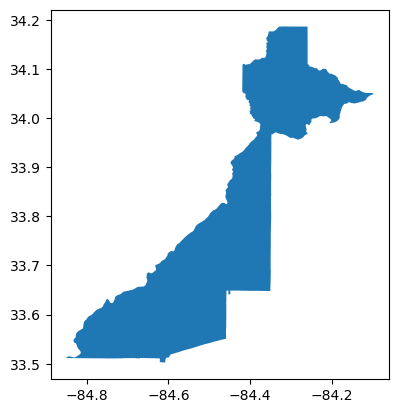

In [15]:
# Loading Fulton County Administrative boundary
# Technically downloading all polling location data, and then filtering for GA, then Fulton county locations
file = '/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/final_project/Polling_Locations/tl_2022_us_county/tl_2022_us_county.shp'
gdf = gpd.read_file(file)
georgia = gdf[gdf['STATEFP']=='13'].copy()
georgia[georgia['NAME']=='Fulton'].plot()

In [276]:
# Equivalent to fulton_race_2, but for all of georgia
race.shape

(1969, 308)

In [321]:
# Need to figure out right data source - should be 1969 rows
# file = '/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/final_project/Polling_Locations/cb_2021_13_tract_500k/cb_2021_13_tract_500k.shp'
file = '/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/final_project/Polling_Locations/tl_2019_13_tract/tl_2019_13_tract.shp'
gdf = gpd.read_file(file)
gdf['GEOID'] = gdf['GEOID'].astype(int)
gdf.shape

(1969, 13)

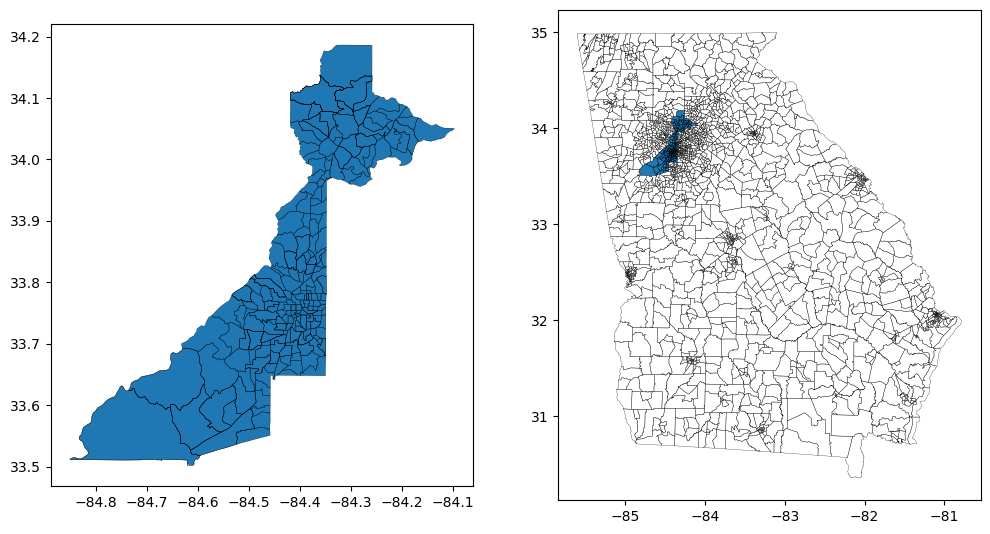

In [329]:
# Proving to myself that I did the merge correctly
fig, ax = plt.subplots(1,2,figsize=(12,8))
georgia[georgia['NAME']=='Fulton'].plot(ax=ax[0])
georgia[georgia['NAME']=='Fulton'].plot(ax=ax[1])
for shape in race_tracts['geometry']:
    x,y = shape.exterior.xy
    ax[0].plot(x,y,'black', linewidth=0.2)
    
for shape in race_tracts_2['geometry']:
    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            x,y = poly.exterior.xy
            ax[1].plot(x,y,'black', linewidth=0.2)
    else:
        x,y = shape.exterior.xy
        ax[1].plot(x,y,'black', linewidth=0.2)

In [1095]:
# DATA FRAME FOR FULTON COUNTY ANALYSIS

# Merging race data and shape data
race_tracts = fulton_tracts.merge(fulton_race_2, left_on='geoid10', right_on='GEOID')
race_tracts = race_tracts.rename(columns={"Ages1664_e18":"population", \
                                         "Black1664_e18": "Black", \
                                         "Asian1664_e18": "Asian", \
                                         "NHWhite1664_e18": "White", \
                                         "Hispanic1664_e18": "Hispanic",\
                                         "mMedBlackHHInc_e18": "Median Black Household Income", \
                                         "mMedAsianHHInc_e18": "Median Asian Household Income", \
                                         "mMedNHWhiteHHInc_e18": "Median White Household Income", \
                                         "mMedHispHHInc_e18": "Median Hispanic Household Income", \
                                         "SHAPE_Length": "Length", \
                                         "SHAPE_Area": "Area", \
                                         "namelsad10": "Census Tract", \
                                         })

race_tracts['% White'] = race_tracts['White'] / race_tracts['population']
race_tracts['% Black'] = race_tracts['Black'] / race_tracts['population']
race_tracts['% Asian'] = race_tracts['Asian'] / race_tracts['population']
race_tracts['% Hispanic'] = race_tracts['Hispanic'] / race_tracts['population']
race_tracts['Majority Black'] = race_tracts['% Black'] > 0.50
race_tracts['Majority Asian'] = race_tracts['% Asian'] > 0.50
race_tracts['Majority White'] = race_tracts['% White'] > 0.50
race_tracts['Majority Hispanic'] = race_tracts['% Hispanic'] > 0.50


race_tracts = race_tracts.loc[:, ['Census Tract', \
                    'geometry', \
                    'population', \
                    'Black', \
                    '% Black', \
                    'Majority Black', \
                    'Asian', \
                    '% Asian', \
                    'Majority Asian', \
                    'White', \
                    '% White', \
                    'Majority White', \
                    'Hispanic', \
                    '% Hispanic', \
                    'Majority Hispanic', \
                    'Median Black Household Income', \
                    'Median Asian Household Income', \
                    'Median White Household Income', \
                    'Median Hispanic Household Income', \
                    'Length', \
                    'areaac', \
                    'Area']]

race_tracts['pop_area'] = race_tracts['population'] / race_tracts['Area']
race_tracts['normalized_pop'] = race_tracts['pop_area'] / np.max(race_tracts['pop_area'])

#### Creating DF for Georgia statewide

In [542]:
race.merge(gdf, left_on='GEOID', right_on='GEOID')

OBJECTID     PlanningRegion ARCModelingArea        GEOID  LogRecNo  \
0            1  Northwest Georgia              No  13083040101      1623   
1            2  Northwest Georgia              No  13083040102      1624   
2            3  Northwest Georgia              No  13083040300      1626   
3            4  Northwest Georgia              No  13083040200      1625   
4            5       Three Rivers             Yes  13045910103      1210   
...        ...                ...             ...          ...       ...   
1964      1965  Georgia Mountains              No  13137000602      2332   
1965      1966  Georgia Mountains              No  13137000100      2325   
1966      1967  Georgia Mountains              No  13137000500      2330   
1967      1968  Georgia Mountains              No  13137000400      2329   
1968      1969  Georgia Mountains              No  13137000300      2328   

     SumLevel                                NAME_x  Ages1664_e18  \
0       Tract      Census Tract 401.01, Dade County          2963   
1       Tract      Census Tract 401.02, Dade County          2078   
2       Tract         Census Tract 403, Dade County          2881   
3       Tract         Census Tract 402, Dade County          2679   
4       Tract  Census Tract 9101.03, Carroll County          3274   
...       ...                                   ...           ...   
1964    Tract   Census Tract 6.02, Habersham County          4651   
1965    Tract      Census Tract 1, Habersham County          2276   
1966    Tract      Census Tract 5, Habersham County          4517   
1967    Tract      Census Tract 4, Habersham County          2901   
1968    Tract      Census Tract 3, Habersham County          2750   

      Ages1664_m18  CivLabFor1664_e18  ...  TRACTCE   NAME_y  \
0              318               2086  ...   040101   401.01   
1              234               1419  ...   040102   401.02   
2              298               2051  ...   040300      403   
3              272               1653  ...   040200      402   
4              359               2470  ...   910103  9101.03   
...            ...                ...  ...      ...      ...   
1964           453               2967  ...   000602     6.02   
1965           282               1634  ...   000100        1   
1966           446               3208  ...   000500        5   
1967           315               2214  ...   000400        4   
1968           300               1768  ...   000300        3   

                  NAMELSAD  MTFCC  FUNCSTAT      ALAND   AWATER     INTPTLAT  \
0      Census Tract 401.01  G5020         S  123640891   169553  +34.9310919   
1      Census Tract 401.02  G5020         S  121363140    77960  +34.7923440   
2         Census Tract 403  G5020         S  103153229   220331  +34.8023519   
3         Census Tract 402  G5020         S  102448047        0  +34.9221354   
4     Census Tract 9101.03  G5020         S   55558010   752911  +33.6914721   
...                    ...    ...       ...        ...      ...          ...   
1964     Census Tract 6.02  G5020         S   67696753   460048  +34.5188568   
1965        Census Tract 1  G5020         S  144714711  1433713  +34.6710504   
1966        Census Tract 5  G5020         S   46327011   433884  +34.5519577   
1967        Census Tract 4  G5020         S   74100000   886892  +34.5402935   
1968        Census Tract 3  G5020         S   35949860   536491  +34.6051274   

          INTPTLON                                           geometry  
0     -085.4641634  POLYGON ((-85.54631 34.86378, -85.54586 34.864...  
1     -085.5237861  POLYGON ((-85.57449 34.81550, -85.57256 34.819...  
2     -085.4532727  POLYGON ((-85.54250 34.66244, -85.54187 34.663...  
3     -085.5569926  POLYGON ((-85.60495 34.98468, -85.60430 34.984...  
4     -084.9611659  POLYGON ((-85.02492 33.66651, -85.02486 33.666...  
...            ...                                                ...  
1964  -083.5965464  POLYGON ((

In [840]:
# DATA FRAME FOR GEORGIA ANALYSIS

# Merging race data and shape data
race_tracts_2 = race.merge(gdf, left_on='GEOID', right_on='GEOID')
race_tracts_2 = race_tracts_2.rename(columns={"Ages1664_e18":"population", \
                                         "Black1664_e18": "Black", \
                                         "Asian1664_e18": "Asian", \
                                         "NHWhite1664_e18": "White", \
                                         "Hispanic1664_e18": "Hispanic",\
                                         "mMedBlackHHInc_e18": "Median Black Household Income", \
                                         "mMedAsianHHInc_e18": "Median Asian Household Income", \
                                         "mMedNHWhiteHHInc_e18": "Median White Household Income", \
                                         "mMedHispHHInc_e18": "Median Hispanic Household Income", \
                                         "SHAPE_Length": "Length", \
                                         "SHAPE_Area": "Area", \
                                         "NAME_x": "Census Tract", \
                                         "County" : "County"
                                         })

race_tracts_2['% White'] = race_tracts_2['White'] / race_tracts_2['population']
race_tracts_2['% Black'] = race_tracts_2['Black'] / race_tracts_2['population']
race_tracts_2['% Asian'] = race_tracts_2['Asian'] / race_tracts_2['population']
race_tracts_2['% Hispanic'] = race_tracts_2['Hispanic'] / race_tracts_2['population']
race_tracts_2['Majority Black'] = race_tracts_2['% Black'] > 0.50
race_tracts_2['Majority Asian'] = race_tracts_2['% Asian'] > 0.50
race_tracts_2['Majority White'] = race_tracts_2['% White'] > 0.50
race_tracts_2['Majority Hispanic'] = race_tracts_2['% Hispanic'] > 0.50


race_tracts_2 = race_tracts_2.loc[:, ['Census Tract', \
                    'geometry', \
                    'population', \
                    'Black', \
                    '% Black', \
                    'Majority Black', \
                    'Asian', \
                    '% Asian', \
                    'Majority Asian', \
                    'White', \
                    '% White', \
                    'Majority White', \
                    'Hispanic', \
                    '% Hispanic', \
                    'Majority Hispanic', \
                    'Median Black Household Income', \
                    'Median Asian Household Income', \
                    'Median White Household Income', \
                    'Median Hispanic Household Income', \
                    'Length', \
#                     'areaac', \
                    'Area', \
                    'County']]

race_tracts_2['pop_area'] = race_tracts_2['population'] / race_tracts_2['Area']
race_tracts_2['normalized_pop'] = race_tracts_2['pop_area'] / np.max(race_tracts_2['pop_area'])

In [841]:
race_tracts_2.shape

(1969, 24)

In [842]:
race_tracts_2.keys()

Index(['Census Tract', 'geometry', 'population', 'Black', '% Black',
       'Majority Black', 'Asian', '% Asian', 'Majority Asian', 'White',
       '% White', 'Majority White', 'Hispanic', '% Hispanic',
       'Majority Hispanic', 'Median Black Household Income',
       'Median Asian Household Income', 'Median White Household Income',
       'Median Hispanic Household Income', 'Length', 'Area', 'County',
       'pop_area', 'normalized_pop'],
      dtype='object')

##### Mapping 2020 Georgia polling locations to census tracts

In [843]:
coords2 = georgia_coords[georgia_coords['lat']!='None'].drop_duplicates(['lat', 'lon'])[['lat', 'lon']]
coords2['lat'] = coords2['lat'].astype(float)
coords2['lon'] = coords2['lon'].astype(float)

In [547]:
# Identifying census tract for each station - 2020

indices = []
tracts = []
for i in range(race_tracts_2['geometry'].shape[0]):
    shape = race_tracts_2['geometry'][i]
    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            x,y = poly.exterior.xy
            for index in coords2.index:
                point = Point(float(coords2.loc[index, :]['lon']), float(coords2.loc[index, :]['lat']))
                if shape.contains(point):
                    lon = float(coords2.loc[index, :]['lon'])
                    lat = float(coords2.loc[index, :]['lat'])
                    tract = race_tracts_2['Census Tract'][i]
                    tracts.append(tract)
                    indices.append(index)
    else:
        x,y = shape.exterior.xy
        for index in coords2.index:
            point = Point(float(coords2.loc[index, :]['lon']), float(coords2.loc[index, :]['lat']))
            if shape.contains(point):
                lon = float(coords2.loc[index, :]['lon'])
                lat = float(coords2.loc[index, :]['lat'])
                tract = race_tracts_2['Census Tract'][i]
                tracts.append(tract)
                indices.append(index)
            
            
#     if isinstance(shape, MultiPolygon):
#         for poly in shape.geoms:
#             x,y = poly.exterior.xy
#             ax[1].plot(x,y,'black', linewidth=0.2)
#     else:
#         x,y = shape.exterior.xy
#         ax[1].plot(x,y,'black', linewidth=0.2)

In [844]:
tract_indices = dict({'index': indices, 'Census Tract': tracts})
tract_indices = pd.DataFrame(tract_indices)
tract_indices = tract_indices.set_index('index')

In [845]:
coords2 = coords2.merge(tract_indices, left_index=True, right_index=True)

In [846]:
race_tracts_2 = race_tracts_2.merge(coords2, how='left', left_on='Census Tract', right_on='Census Tract')

In [847]:
georgia_station_count = race_tracts_2.groupby('Census Tract')['lat'].count().to_frame().rename(columns={'lat': 'Polling Station Count'})

In [848]:
race_tracts_2 = race_tracts_2.merge(georgia_station_count, how='left', on='Census Tract')
race_tracts_2['Polling Station Count'] = race_tracts_2['Polling Station Count'].to_frame().fillna(0)
race_tracts_2

Census Tract  \
0     Census Tract 401.01, Dade County   
1     Census Tract 401.01, Dade County   
2     Census Tract 401.02, Dade County   
3        Census Tract 403, Dade County   
4        Census Tract 402, Dade County   
...                                ...   
2325  Census Tract 1, Habersham County   
2326  Census Tract 5, Habersham County   
2327  Census Tract 4, Habersham County   
2328  Census Tract 4, Habersham County   
2329  Census Tract 3, Habersham County   

                                               geometry  population  Black  \
0     POLYGON ((-85.54631 34.86378, -85.54586 34.864...        2963     16   
1     POLYGON ((-85.54631 34.86378, -85.54586 34.864...        2963     16   
2     POLYGON ((-85.57449 34.81550, -85.57256 34.819...        2078      0   
3     POLYGON ((-85.54250 34.66244, -85.54187 34.663...        2881     30   
4     POLYGON ((-85.60495 34.98468, -85.60430 34.984...        2679     24   
...                                                 ...         ...    ...   
2325  POLYGON ((-83.49770 34.63777, -83.49771 34.638...        2276     27   
2326  POLYGON ((-83.59114 34.56958, -83.59100 34.569...        4517    192   
2327  POLYGON ((-83.52718 34.51109, -83.52650 34.511...        2901     25   
2328  POLYGON ((-83.52718 34.51109, -83.52650 34.511...        2901     25   
2329  POLYGON ((-83.55935 34.59274, -83.55924 34.592...        2750     99   

       % Black  Majority Black  Asian   % Asian  Majority Asian  White  ...  \
0     0.005400           False    122  0.041174           False   2781  ...   
1     0.005400           False    122  0.041174           False   2781  ...   
2     0.000000           False      0  0.000000           False   1965  ...   
3     0.010413           False     55  0.019091           False   2626  ...   
4     0.008959           False      0  0.000000           False   2489  ...   
...        ...             ...    ...       ...             ...    ...  ...   
2325  0.011863           False     13  0.005712           False   2136  ...   
2326  0.042506           False      9  0.001992           False   3684  ...   
2327  0.008618           False    182  0.062737           False   2158  ...   
2328  0.008618           False    182  0.062737           False   2158  ...   
2329  0.036000           False     15  0.005455           False   2275  ...   

      Median White Household Income  Median Hispanic Household Income  \
0                           35240.0                               NaN   
1                           35240.0                               NaN   
2                           41332.0                               NaN   
3                           52857.0                               NaN   
4                           52571.0                               NaN   
...                             ...                               ...   
2325                        49567.0                               NaN   
2326                        47842.0                           54878.0   
2327                        52096.0                           47417.0   
2328                        52096.0                           47417.0   
2329                        44556.0                               NaN   

        Length      Area            County       pop_area  normalized_pop  \
0     0.937368  0.012217       Dade County  242535.840626        0.002696   
1     0.937368  0.012217       Dade County  242535.840626        0.002696   
2     0.679510  0.011957       Dade County  173784.047918        0.001932   
3     1.175428  0.010181       Dade County  282966.086769        0.003146   
4     0.675701  0.010106       Dade County  265084.015588        0.002947   
...        ...       ...               ...            ...             ...   
2325  0.651150  0.014373  Habersham County  158357.222381        0.001761   
2326  0.332011  0.004593  Habersham County  983473.163469        0.010934   
2327  0.393050  0.007364  Habersham County  393937.901499        

In [849]:
race_tracts_2['Polling Station Count per capita'] = race_tracts_2['Polling Station Count'] / race_tracts_2['population']
race_tracts_2['Polling Station Count per capita normalized'] = race_tracts_2['Polling Station Count per capita'] / np.max(race_tracts_2['Polling Station Count per capita'])

##### Mapping 2020 fulton county polling locations to census tracts 

In [401]:
# Identifying census tract for each station - 2020

indices = []
tracts = []
for i in range(race_tracts['geometry'].shape[0]):
    shape = race_tracts['geometry'][i]
    x,y = shape.exterior.xy
    for index in coords.index:
        point = Point(float(coords.loc[index, :]['lon']), float(coords.loc[index, :]['lat']))
        if shape.contains(point):
            lon = float(coords.loc[index, :]['lon'])
            lat = float(coords.loc[index, :]['lat'])
            tract = race_tracts['Census Tract'][i]
            tracts.append(tract)
            indices.append(index)

In [402]:
tract_indices = dict({'index': indices, 'Census Tract': tracts})
tract_indices = pd.DataFrame(tract_indices)
tract_indices = tract_indices.set_index('index')

In [411]:
tract_indices

Census Tract
index                     
1395       Census Tract 23
1342       Census Tract 25
1501       Census Tract 25
1333       Census Tract 26
1300       Census Tract 29
...                    ...
1274   Census Tract 116.23
1566   Census Tract 116.23
1384   Census Tract 116.25
1299      Census Tract 119
1390      Census Tract 119

[167 rows x 1 columns]

In [414]:
coords

lat        lon         Census Tract
1183  33.831438 -84.378180   Census Tract 96.03
1185  33.587177 -84.518918  Census Tract 105.11
1193  33.943457 -84.404576  Census Tract 102.04
1196  33.705693 -84.461678   Census Tract 76.02
1198  33.763735 -84.441343   Census Tract 83.01
...         ...        ...                  ...
1553  33.740311 -84.420893      Census Tract 42
1562  33.690414 -84.511569   Census Tract 77.06
1566  34.034914 -84.181616  Census Tract 116.23
1569  33.666070 -84.478903  Census Tract 113.03
1570  34.072650 -84.367053  Census Tract 115.05

[167 rows x 3 columns]

In [413]:
coords = coords.merge(tract_indices, left_index=True, right_index=True)

In [415]:
coords

lat        lon         Census Tract
1183  33.831438 -84.378180   Census Tract 96.03
1185  33.587177 -84.518918  Census Tract 105.11
1193  33.943457 -84.404576  Census Tract 102.04
1196  33.705693 -84.461678   Census Tract 76.02
1198  33.763735 -84.441343   Census Tract 83.01
...         ...        ...                  ...
1553  33.740311 -84.420893      Census Tract 42
1562  33.690414 -84.511569   Census Tract 77.06
1566  34.034914 -84.181616  Census Tract 116.23
1569  33.666070 -84.478903  Census Tract 113.03
1570  34.072650 -84.367053  Census Tract 115.05

[167 rows x 3 columns]

##### Mapping 2022 polling locations to census tracts

In [1088]:
# Identifying census tract for each station - 2022

indices = []
tracts = []
for i in range(race_tracts['geometry'].shape[0]):
    shape = race_tracts['geometry'][i]
    x,y = shape.exterior.xy
    for index in coords_2022.index:
        point = Point(float(coords_2022.loc[index, :]['lon']), float(coords_2022.loc[index, :]['lat']))
        if shape.contains(point):
            lon = float(coords_2022.loc[index, :]['lon'])
            lat = float(coords_2022.loc[index, :]['lat'])
            tract = race_tracts['Census Tract'][i]
            tracts.append(tract)
            indices.append(index)

In [1089]:
tract_indices = dict({'index': indices, 'Census Tract': tracts})
tract_indices = pd.DataFrame(tract_indices)
tract_indices = tract_indices.set_index('index')

In [1090]:
tract_indices

Census Tract
index                     
22         Census Tract 25
23         Census Tract 25
22         Census Tract 25
23         Census Tract 25
12         Census Tract 30
...                    ...
136    Census Tract 116.26
137    Census Tract 116.26
138    Census Tract 116.26
4         Census Tract 119
4         Census Tract 119

[253 rows x 1 columns]

In [1091]:
coords_2022

lat        lon
0    33.735016 -84.364665
1    33.731229 -84.352597
2    33.698022 -84.372116
3    33.734382 -84.387905
4    33.753727 -84.374564
..         ...        ...
222  33.957182 -84.361880
223  30.540999 -87.711359
224  33.598146 -84.515632
225  33.587653 -84.557224
226  33.589888 -84.589461

[222 rows x 2 columns]

In [1092]:
coords_2022 = coords_2022.merge(tract_indices, left_index=True, right_index=True)
coords_2022 = coords_2022.drop_duplicates()

In [1094]:
coords_2022

lat        lon         Census Tract
0    33.735016 -84.364665      Census Tract 53
1    33.731229 -84.352597      Census Tract 52
2    33.698022 -84.372116   Census Tract 70.02
3    33.734382 -84.387905   Census Tract 55.01
4    33.753727 -84.374564     Census Tract 119
..         ...        ...                  ...
221  33.959848 -84.349567  Census Tract 101.22
222  33.957182 -84.361880  Census Tract 101.17
224  33.598146 -84.515632  Census Tract 105.11
225  33.587653 -84.557224  Census Tract 105.13
226  33.589888 -84.589461  Census Tract 105.13

[154 rows x 3 columns]

##### Mapping 2018 polling locations to census tracts

In [953]:
# Identifying census tract for each station - 2018

indices = []
tracts = []
for i in range(race_tracts_2018['geometry'].shape[0]):
    shape = race_tracts_2018['geometry'][i]
    x,y = shape.exterior.xy
    for index in coords_2018.index:
        point = Point(float(coords_2018.loc[index, :]['lon']), float(coords_2018.loc[index, :]['lat']))
        if shape.contains(point):
            lon = float(coords_2018.loc[index, :]['lon'])
            lat = float(coords_2018.loc[index, :]['lat'])
            tract = race_tracts_2018['Census Tract'][i]
            tracts.append(tract)
            indices.append(index)

In [954]:
tract_indices = dict({'index': indices, 'Census Tract': tracts})
tract_indices = pd.DataFrame(tract_indices)
tract_indices = tract_indices.set_index('index')

In [955]:
tract_indices

Census Tract
index                                    
1389       Census Tract 23, Fulton County
1323       Census Tract 25, Fulton County
1475       Census Tract 25, Fulton County
1390       Census Tract 30, Fulton County
1377       Census Tract 31, Fulton County
...                                   ...
1526   Census Tract 116.19, Fulton County
1542   Census Tract 116.21, Fulton County
1271   Census Tract 116.23, Fulton County
1541   Census Tract 116.23, Fulton County
1381      Census Tract 119, Fulton County

[131 rows x 1 columns]

In [956]:
coords_2018

lat        lon
1169  34.017712 -84.363968
1173  34.021069 -84.161731
1174  33.736205 -84.422354
1175  33.771529 -84.387836
1178  33.763735 -84.441343
...         ...        ...
1528  33.632086 -84.526326
1538  33.690414 -84.511569
1541  34.034914 -84.181616
1542  34.090466 -84.237632
1548  34.022511 -84.355184

[124 rows x 2 columns]

In [958]:
coords_2018 = coords_2018.merge(tract_indices, left_index=True, right_index=True)
coords_2018 = coords_2018.drop_duplicates()

In [959]:
coords_2018

lat        lon                        Census Tract
1169  34.017712 -84.363968  Census Tract 114.23, Fulton County
1174  33.736205 -84.422354      Census Tract 42, Fulton County
1175  33.771529 -84.387836   Census Tract 10.01, Fulton County
1178  33.763735 -84.441343   Census Tract 83.01, Fulton County
1179  34.075384 -84.296628  Census Tract 116.10, Fulton County
...         ...        ...                                 ...
1528  33.632086 -84.526326  Census Tract 105.11, Fulton County
1538  33.690414 -84.511569   Census Tract 77.06, Fulton County
1541  34.034914 -84.181616  Census Tract 116.23, Fulton County
1542  34.090466 -84.237632  Census Tract 116.21, Fulton County
1548  34.022511 -84.355184  Census Tract 114.05, Fulton County

[123 rows x 3 columns]

##### Mapping 2016 polling locations to census tracts

In [982]:
# Identifying census tract for each station - 2016

indices = []
tracts = []
for i in range(race_tracts_2016['geometry'].shape[0]):
    shape = race_tracts_2016['geometry'][i]
    x,y = shape.exterior.xy
    for index in coords_2016.index:
        point = Point(float(coords_2016.loc[index, :]['lon']), float(coords_2016.loc[index, :]['lat']))
        if shape.contains(point):
            lon = float(coords_2016.loc[index, :]['lon'])
            lat = float(coords_2016.loc[index, :]['lat'])
            tract = race_tracts_2016['Census Tract'][i]
            tracts.append(tract)
            indices.append(index)

In [983]:
tract_indices = dict({'index': indices, 'Census Tract': tracts})
tract_indices = pd.DataFrame(tract_indices)
tract_indices = tract_indices.set_index('index')

In [984]:
tract_indices

Census Tract
index                                    
1268       Census Tract 23, Fulton County
1250       Census Tract 25, Fulton County
1260       Census Tract 25, Fulton County
1470       Census Tract 28, Fulton County
1278       Census Tract 30, Fulton County
...                                   ...
1357   Census Tract 116.19, Fulton County
1506   Census Tract 116.19, Fulton County
1387   Census Tract 116.21, Fulton County
1490   Census Tract 116.23, Fulton County
1230      Census Tract 119, Fulton County

[137 rows x 1 columns]

In [986]:
coords_2016

lat        lon
1191  33.736205 -84.422354
1192  33.754829 -84.513820
1194  33.771529 -84.387836
1200  33.725739 -84.391395
1203  33.690414 -84.511569
...         ...        ...
1537  33.556432 -84.522744
1544  33.705693 -84.461678
1546  34.073881 -84.292229
1547  33.731003 -84.441772
1549  33.729584 -84.392532

[138 rows x 2 columns]

In [987]:
coords_2016 = coords_2016.merge(tract_indices, left_index=True, right_index=True)
coords_2016 = coords_2016.drop_duplicates()

In [988]:
coords_2016

lat        lon                        Census Tract
1191  33.736205 -84.422354      Census Tract 42, Fulton County
1192  33.754829 -84.513820   Census Tract 78.06, Fulton County
1194  33.771529 -84.387836   Census Tract 10.01, Fulton County
1200  33.725739 -84.391395     Census Tract 120, Fulton County
1203  33.690414 -84.511569   Census Tract 77.06, Fulton County
...         ...        ...                                 ...
1537  33.556432 -84.522744  Census Tract 105.15, Fulton County
1544  33.705693 -84.461678   Census Tract 76.02, Fulton County
1546  34.073881 -84.292229  Census Tract 116.16, Fulton County
1547  33.731003 -84.441772      Census Tract 61, Fulton County
1549  33.729584 -84.392532     Census Tract 120, Fulton County

[137 rows x 3 columns]

##### Merging into race_tracts df

In [1096]:
race_tracts_2022 = race_tracts.copy()

In [1098]:
race_tracts = race_tracts.merge(coords, how='left', on='Census Tract')
race_tracts_2022 = race_tracts_2022.merge(coords_2022, how='left', on='Census Tract')

In [1099]:
# Identifying number of polling stations in each census tract
station_count = coords.groupby('Census Tract')['lat'].count().to_frame().rename(columns={'lat': 'Polling Station Count'})
station_count_2022 = coords_2022.groupby('Census Tract')['lat'].count().to_frame().rename(columns={'lat': 'Polling Station Count'})

In [1100]:
# Merging polling station count info with full df
race_tracts = race_tracts.merge(station_count, how='left', on='Census Tract')
race_tracts_2022 = race_tracts_2022.merge(station_count_2022, how='left', on='Census Tract')
race_tracts['Polling Station Count'] = race_tracts['Polling Station Count'].to_frame().fillna(0)
race_tracts_2022['Polling Station Count'] = race_tracts_2022['Polling Station Count'].to_frame().fillna(0)
race_tracts

Census Tract                                           geometry  \
0        Census Tract 23  POLYGON ((-84.42117000008028 33.77139199981931...   
1        Census Tract 24  POLYGON ((-84.43353000026815 33.75552099982870...   
2        Census Tract 25  POLYGON ((-84.40783999982564 33.75636699972605...   
3        Census Tract 25  POLYGON ((-84.40783999982564 33.75636699972605...   
4        Census Tract 26  POLYGON ((-84.40203400024379 33.76342900017701...   
..                   ...                                                ...   
254  Census Tract 116.25  POLYGON ((-84.20987999953815 34.04531199966071...   
255  Census Tract 116.26  POLYGON ((-84.17773700018668 34.06952600000925...   
256     Census Tract 118  POLYGON ((-84.40818799952721 33.77455899977652...   
257     Census Tract 119  POLYGON ((-84.39324300026885 33.75460400016128...   
258     Census Tract 119  POLYGON ((-84.39324300026885 33.75460400016128...   

     population  Black   % Black  Majority Black  Asian   % Asian  \
0           891    774  0.868687            True      0  0.000000   
1          1825   1685  0.923288            True      0  0.000000   
2          1716   1531  0.892191            True     13  0.007576   
3          1716   1531  0.892191            True     13  0.007576   
4          1088   1019  0.936581            True     22  0.020221   
..          ...    ...       ...             ...    ...       ...   
254        5354    526  0.098244           False   1534  0.286515   
255        6324    738  0.116698           False   1997  0.315781   
256        1741   1218  0.699598            True    151  0.086732   
257        2561   1247  0.486919           False    121  0.047247   
258        2561   1247  0.486919           False    121  0.047247   

     Majority Asian  White  ...  Median White Household Income  \
0             False     98  ...                            NaN   
1             False    111  ...                            NaN   
2             False     89  ...                            NaN   
3             False     89  ...                            NaN   
4             False     14  ...                            NaN   
..              ...    ...  ...                            ...   
254           False   2853  ...                       106932.0   
255           False   2965  ...                        95083.0   
256           False    300  ...                         2499.0   
257           False   1031  ...                        52917.0   
258           False   1031  ...                        52917.0   

     Median Hispanic Household Income    Length         areaac      Area  \
0                                 NaN  0.051850   277.33258157  0.000109   
1                                 NaN  0.050614   334.08361991  0.000132   
2                                 NaN  0.036889   215.48088541  0.000085   
3                                 NaN  0.036889   215.48088541  0.000085   
4                                 NaN  0.039820   236.16208858  0.000093   
..                                ...       ...            ...       ...   
254                           61051.0  0.137991  1507.59255431  0.000596   
255                          100472.0  0.110421   1432.5315835  0.000566   
256                           40417.0  0.069066   462.01757011  0.000182   
257                               NaN  0.070226   378.20780196  0.000149   
258                               NaN  0.070226   378.20780196  0.000149   

         pop_area  normalized_pop        lat        lon  Polling Station Count  
0    8.155651e+06        0.090671  33.769778 -84.416820                    1.0  
1    1.386859e+07        0.154186        NaN        NaN                    0.0  
2    2.021765e+07        0.224772  33.760259 -84.413143                    2.0  
3    2.021765e+07        0.224772  33.763058 -84.413460                    2.0  
4    1.169612e+07        0.130033  33.757117 -84.406504                    1.0  
..            ...             ...        .

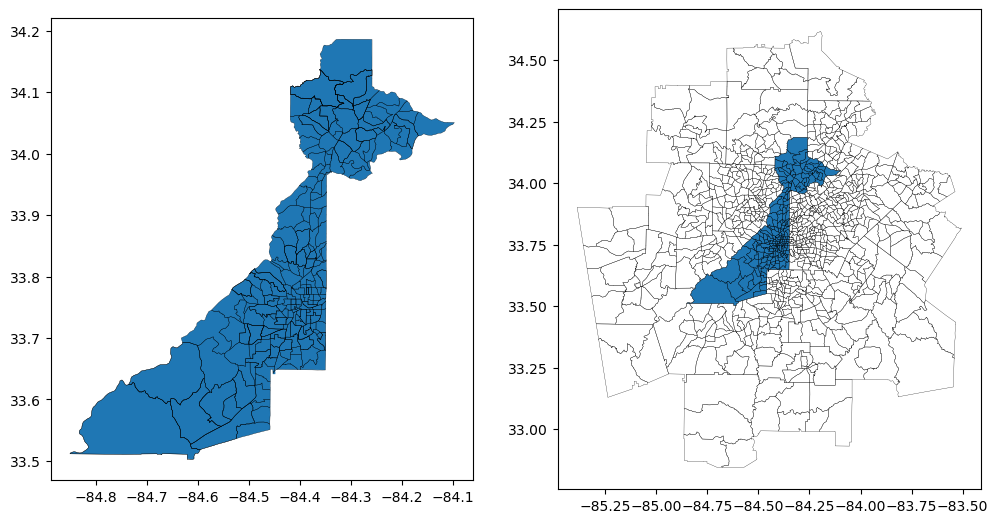

In [110]:
# Proving to myself that I did the merge correctly
fig, ax = plt.subplots(1,2,figsize=(12,8))
georgia[georgia['NAME']=='Fulton'].plot(ax=ax[0])
georgia[georgia['NAME']=='Fulton'].plot(ax=ax[1])
for shape in race_tracts['geometry']:
    x,y = shape.exterior.xy
    ax[0].plot(x,y,'black', linewidth=0.2)
    
for shape in fulton_tracts['geometry']:
    x,y = shape.exterior.xy
    ax[1].plot(x,y,'black', linewidth=0.2)

In [167]:
# Reading in 2022 polling location data
# path = '/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/final_project/Polling_Locations/Fulton_2022_locations.pdf'
# df = tabula.read_pdf(path, pages = 6)[0]
# Need to install Java

##### TO DO: ADDRESS NULL COORDINATES ISSUE

In [112]:
# TO BE DELETED
# TRYING TO ADDRESS NULL COORDS ISSUE
null = fulton[fulton['lat']=='null'].copy()
null
locator = Nominatim(user_agent='myGeocoder')
# location = locator.geocode(“Champ de Mars, Paris, France”)
location = locator.geocode("121 N LaSalle St, Chicago")
null['Location'] = null['address'].apply(lambda x: locator.geocode(x))

### Exploratory Data Analysis

In [1102]:
race_tracts['Polling Station Count per capita'] = race_tracts['Polling Station Count'] / race_tracts['population']
race_tracts_2022['Polling Station Count per capita'] = race_tracts_2022['Polling Station Count'] / race_tracts_2022['population']
race_tracts['Polling Station Count per capita normalized'] = race_tracts['Polling Station Count per capita'] / np.max(race_tracts['Polling Station Count per capita'])
race_tracts_2022['Polling Station Count per capita normalized'] = race_tracts_2022['Polling Station Count per capita'] / np.max(race_tracts_2022['Polling Station Count per capita'])

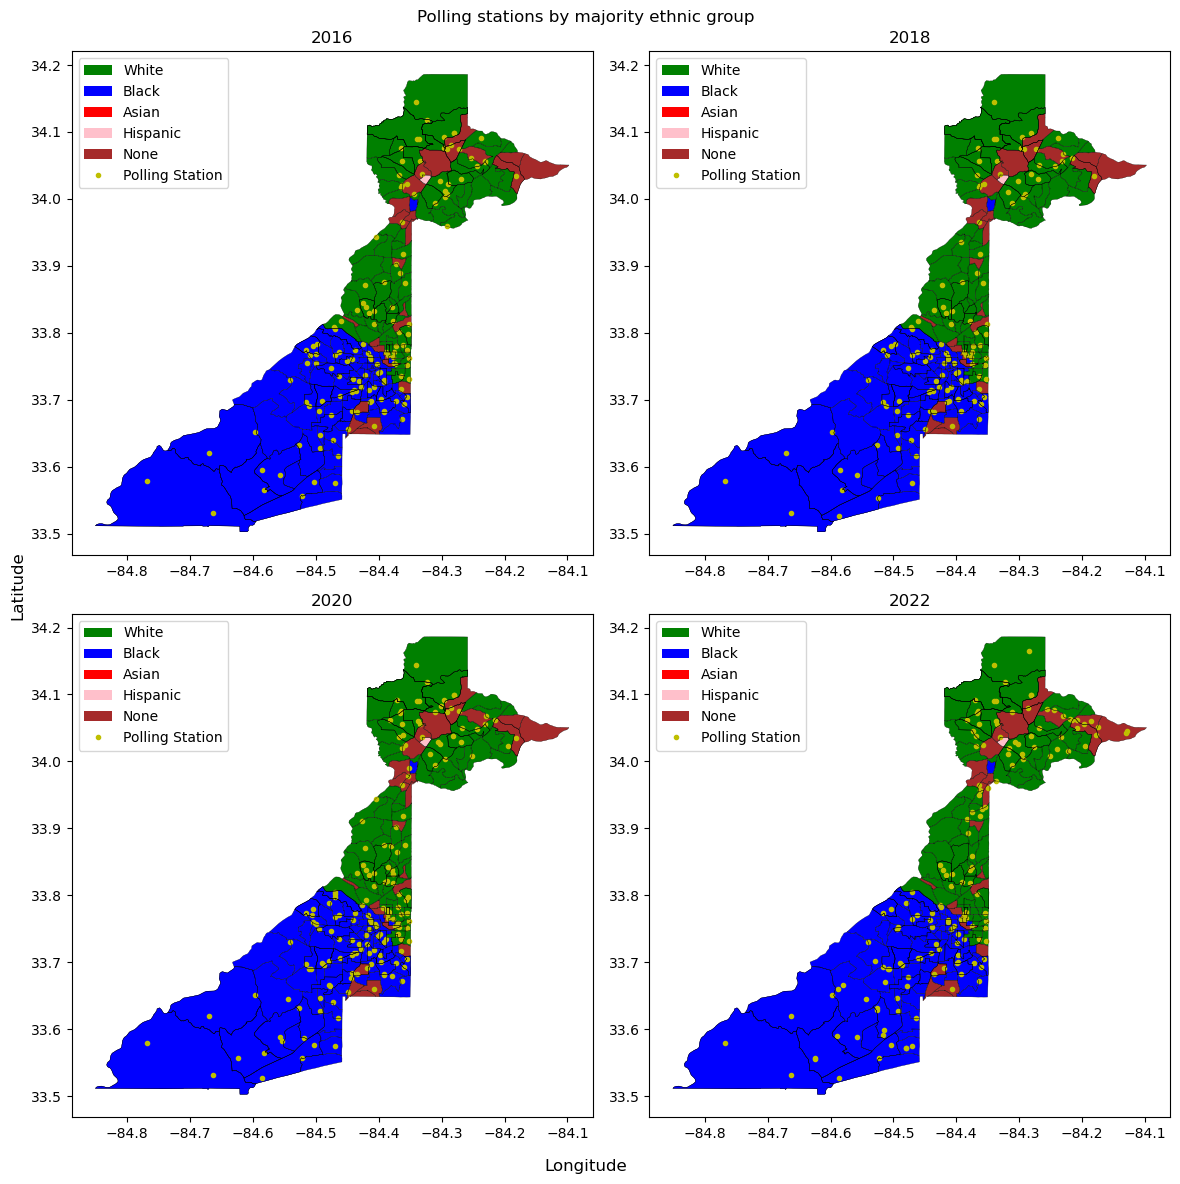

In [1136]:
xmin, ymin, xmax, ymax = georgia[georgia['NAME']=='Fulton']['geometry'].total_bounds
fig, ax = plt.subplots(2,2, figsize=(12,12))

# Plotting polling station locations in Fulton county - 2016
for index in coords_2016.index:
    point = Point(coords_2016.loc[index, 'lon'], coords_2016.loc[index, 'lat'])
    if georgia[georgia['NAME']=='Fulton']['geometry'].contains(point).values[0]:
        ax[0][0].plot(coords_2016.loc[index, :]['lon'], coords_2016.loc[index, :]['lat'],"y.")

# Plotting polling station locations in Fulton county - 2018
for index in coords_2018.index:
    point = Point(coords_2018.loc[index, 'lon'], coords_2018.loc[index, 'lat'])
    if georgia[georgia['NAME']=='Fulton']['geometry'].contains(point).values[0]:
        ax[0][1].plot(coords_2018.loc[index, :]['lon'], coords_2018.loc[index, :]['lat'],"y.")

# Plotting polling station locations in Fulton county - 2020
for index in coords.index:
    point = Point(float(coords.loc[index, :]['lon']), float(coords.loc[index, :]['lat']))
    if georgia[georgia['NAME']=='Fulton']['geometry'].contains(point).values[0]:
        ax[1][0].plot(float(coords.loc[index, :]['lon']), float(coords.loc[index, :]['lat']),"y.")
        
# Plotting polling station locations in Fulton county - 2022
for index in coords_2022.index:
    point = Point(float(coords_2022.loc[index, :]['lon']), float(coords_2022.loc[index, :]['lat']))
    if georgia[georgia['NAME']=='Fulton']['geometry'].contains(point).values[0]:
        ax[1][1].plot(float(coords_2022.loc[index, :]['lon']), float(coords_2022.loc[index, :]['lat']),"y.")
    
for i in range(race_tracts['geometry'].shape[0]):
    shape = race_tracts['geometry'][i]
    x,y = shape.exterior.xy
    ax[0][0].plot(x,y,'black', linewidth=0.2)
    ax[0][1].plot(x,y,'black', linewidth=0.2)
    ax[1][0].plot(x,y,'black', linewidth=0.2)
    ax[1][1].plot(x,y,'black', linewidth=0.2)
    
    # I can fill based on different values
    if race_tracts['Majority White'][i]:
        ax[0][0].fill(x,y, 'green')
        ax[0][1].fill(x,y, 'green')
        ax[1][0].fill(x,y, 'green')
        ax[1][1].fill(x,y, 'green')
    elif race_tracts['Majority Black'][i]:
        ax[0][0].fill(x,y, 'blue')
        ax[0][1].fill(x,y, 'blue')
        ax[1][0].fill(x,y, 'blue')
        ax[1][1].fill(x,y, 'blue')
    elif race_tracts['Majority Asian'][i]:
        ax[0][0].fill(x,y, 'orange')
        ax[0][1].fill(x,y, 'orange')
        ax[1][0].fill(x,y, 'orange')
        ax[1][1].fill(x,y, 'orange')
    elif race_tracts['Majority Hispanic'][i]:
        ax[0][0].fill(x,y, 'pink')
        ax[0][1].fill(x,y, 'pink')
        ax[1][0].fill(x,y, 'pink')
        ax[1][1].fill(x,y, 'pink')
    else:
        ax[0][0].fill(x,y, 'brown')
        ax[0][1].fill(x,y, 'brown')
        ax[1][0].fill(x,y, 'brown')
        ax[1][1].fill(x,y, 'brown')
        
        
for j in range(2):
    for k in range(2):
        ax[j][k].fill([], 'green', label='White')
        ax[j][k].fill([], 'blue', label='Black')
        ax[j][k].fill([], 'red', label='Asian')
        ax[j][k].fill([], 'pink', label='Hispanic')
        ax[j][k].fill([], 'brown', label='None')
        ax[j][k].plot([], 'y.', label='Polling Station')
        ax[j][k].legend()

ax[0][0].set_title("2016")    
ax[0][1].set_title("2018")
ax[1][0].set_title("2020")
ax[1][1].set_title("2022")
fig.suptitle("Polling stations by majority ethnic group")
fig.supxlabel("Longitude")
fig.supylabel("Latitude")

plt.tight_layout()
path = '/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/final_project/Polling_Locations/polling_place_locations.png'
plt.savefig(path)
plt.show()

In [899]:
coords_2016.shape

(138, 2)

In [900]:
coords_2018.shape

(123, 4)

In [902]:
coords.shape

(167, 3)

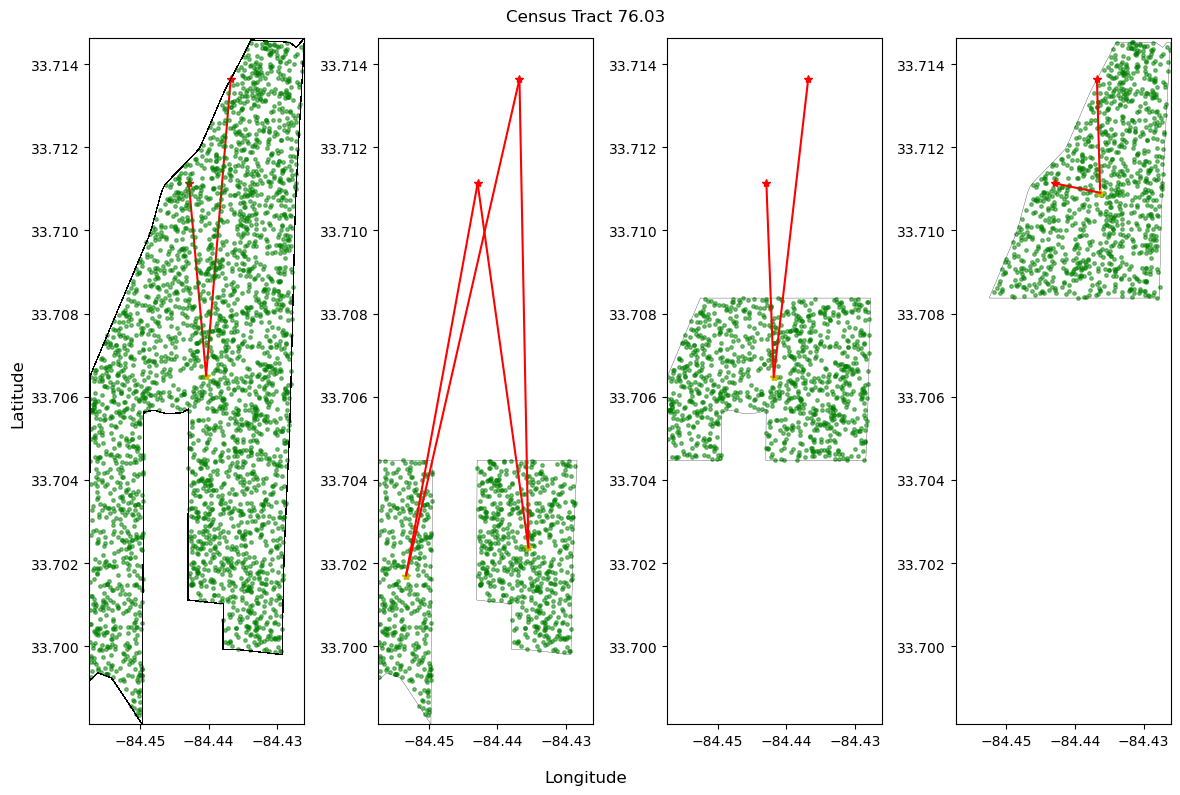

In [1138]:
index = 10
poly = race_tracts.iloc[index]['geometry']
pop = race_tracts.iloc[index]['population']
random_points = random_points_within(poly, pop, 1)
num_polys = 3
points_chunks, slices = split_points(poly, pop, random_points, num_polys)
polygons = split_polygon(poly, slices, points_chunks)
display_poly_split(poly, polygons, num_polys, race_tracts, random_points, points_chunks, index)

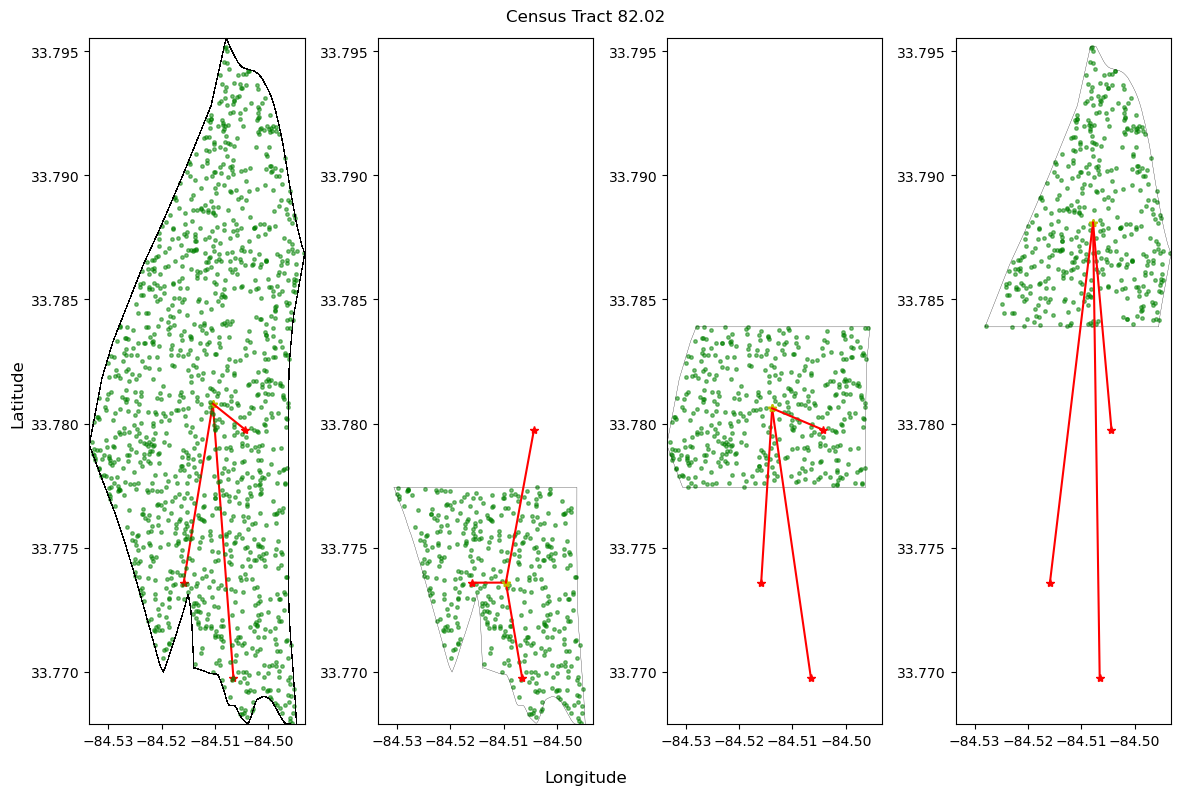

In [1140]:
index = 101
poly = race_tracts.iloc[index]['geometry']
pop = race_tracts.iloc[index]['population']
random_points = random_points_within(poly, pop, 1)
num_polys = 3
points_chunks, slices = split_points(poly, pop, random_points, num_polys)
polygons = split_polygon(poly, slices, points_chunks)
display_poly_split(poly, polygons, num_polys, race_tracts, random_points, points_chunks, index)

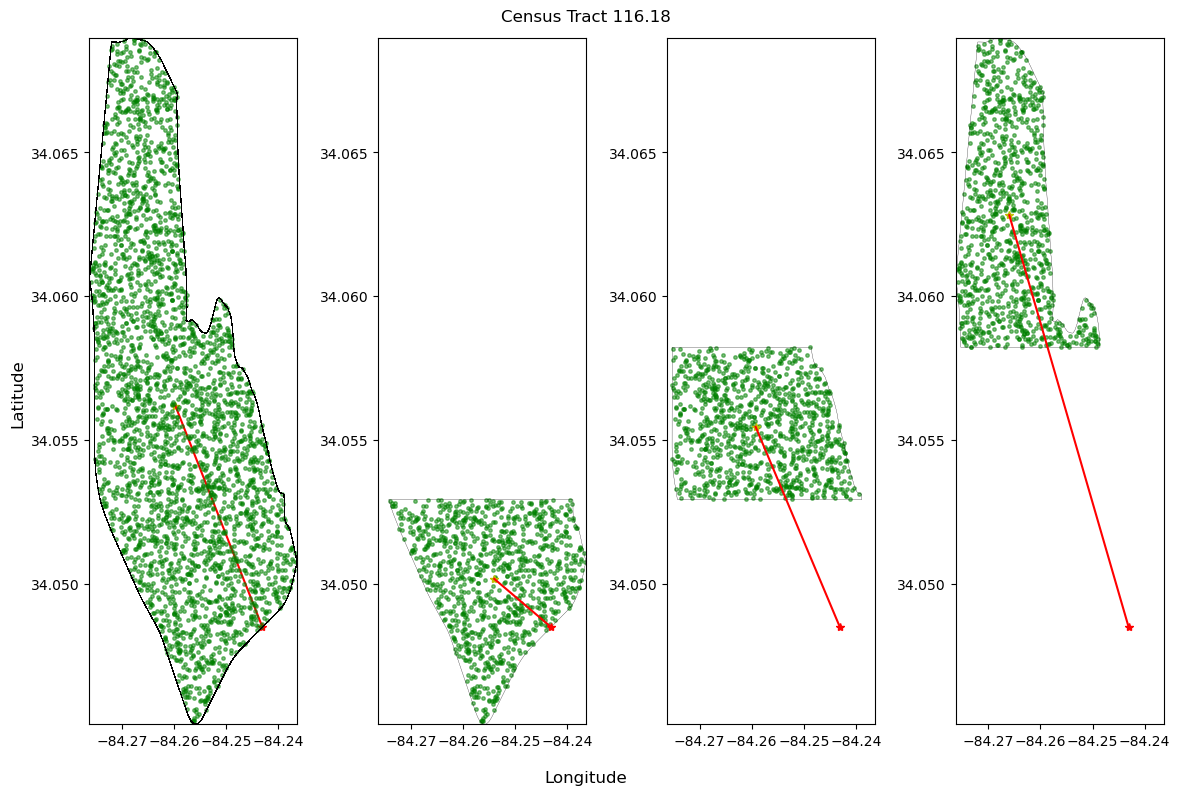

In [1139]:
index = 246
poly = race_tracts.iloc[index]['geometry']
pop = race_tracts.iloc[index]['population']
random_points = random_points_within(poly, pop, 1)
num_polys = 3
points_chunks, slices = split_points(poly, pop, random_points, num_polys)
polygons = split_polygon(poly, slices, points_chunks)
display_poly_split(poly, polygons, num_polys, race_tracts, random_points, points_chunks, index)

In [420]:
unique_tracts = np.unique(race_tracts['Census Tract'].values)

In [421]:
print('There are {} unique polling stations across {} census tracts.'.format(\
        int(race_tracts['Polling Station Count'].sum()), unique_tracts.shape[0]))
print('Fulton County has {} people.'.format(race_tracts['population'].sum()))
print('Therefore, there should be one polling station for every ~{} people'.format(\
        int(np.round(race_tracts['population'].sum() / race_tracts['Polling Station Count'].sum()))))

There are 297 unique polling stations across 204 census tracts.
Fulton County has 936263 people.
Therefore, there should be one polling station for every ~3152 people


In [422]:
target_stations = np.ceil(race_tracts['population'] / 3169)
target_stations.sum()

427.0

### 2020: Calculate distance travelled compared to centroid for each census tract

In [423]:
race_tracts.keys()

Index(['Census Tract', 'geometry', 'population', 'Black', '% Black',
       'Majority Black', 'Asian', '% Asian', 'Majority Asian', 'White',
       '% White', 'Majority White', 'Hispanic', '% Hispanic',
       'Majority Hispanic', 'Median Black Household Income',
       'Median Asian Household Income', 'Median White Household Income',
       'Median Hispanic Household Income', 'Length', 'areaac', 'Area',
       'pop_area', 'normalized_pop', 'lat', 'lon', 'Polling Station Count',
       'Polling Station Count per capita',
       'Polling Station Count per capita normalized'],
      dtype='object')

In [430]:
poll_site_distances = []
i=0
# while i < race_tracts.shape[0]:

# i=239
while i < race_tracts.shape[0]:
#     print(i)
    if i % 20 ==0:
        print(i)
    polygon = race_tracts['geometry'][i]
    population = race_tracts['population'][i]
    num_stations = int(ra]ce_tracts['Polling Station Count'][i])
    tract = race_tracts['Census Tract'][i]
    lat = []
    lon = []
    if num_stations > 1:
        for j in range(num_stations):
            lat.append(race_tracts['lat'][i+j])
            lon.append(race_tracts['lon'][i+j])
        i = i + num_stations - 1
    else:
        lat = [race_tracts['lat'][i]]
        lon = [race_tracts['lon'][i]]
    dist_to_poll = calculate_distance_to_poll(polygon, population, num_stations, lat, lon, race_tracts, tract)
    poll_site_distances.append([tract, dist_to_poll])
    i = i +1

distance_df = pd.DataFrame(np.array(poll_site_distances))
distance_df = distance_df.rename(columns={0:"Census Tract", 1: "Total Distance"})

0
20
40
60
80
100
120
160
180
240


In [431]:
distance_df

Census Tract      Total Distance
0        Census Tract 23  0.8368391958852337
1        Census Tract 24   13.50453104482941
2        Census Tract 25  1.9459993820553683
3        Census Tract 26  1.7846661981707372
4        Census Tract 28  17.405558727874343
..                   ...                 ...
199  Census Tract 116.23   236.7791248007463
200  Census Tract 116.25    6.22962987675227
201  Census Tract 116.26  105.32622610447847
202     Census Tract 118   5.779513609237837
203     Census Tract 119  16.875673101767664

[204 rows x 2 columns]

In [432]:
temporary_df = race_tracts.merge(distance_df, how='left', on='Census Tract').fillna(-1000000)
temporary_df['Normalized Total Distance'] = temporary_df['Total Distance'].astype(float) / np.max(temporary_df['Total Distance'].astype(float))
temporary_df['Total Distance per capita'] = temporary_df['Total Distance'].astype(float) / temporary_df['population'].astype(float)
temporary_df['Total Distance per capita normalized'] = temporary_df['Total Distance per capita'] / np.max(temporary_df['Total Distance per capita'])
temporary_df['Total Distance per capita km'] = temporary_df['Total Distance per capita'] * np.cos(temporary_df['lat'].astype(float)/180*np.pi) * 111.11

In [433]:
temporary_df

Census Tract                                           geometry  \
0        Census Tract 23  POLYGON ((-84.42117000008028 33.77139199981931...   
1        Census Tract 24  POLYGON ((-84.43353000026815 33.75552099982870...   
2        Census Tract 25  POLYGON ((-84.40783999982564 33.75636699972605...   
3        Census Tract 25  POLYGON ((-84.40783999982564 33.75636699972605...   
4        Census Tract 26  POLYGON ((-84.40203400024379 33.76342900017701...   
..                   ...                                                ...   
254  Census Tract 116.25  POLYGON ((-84.20987999953815 34.04531199966071...   
255  Census Tract 116.26  POLYGON ((-84.17773700018668 34.06952600000925...   
256     Census Tract 118  POLYGON ((-84.40818799952721 33.77455899977652...   
257     Census Tract 119  POLYGON ((-84.39324300026885 33.75460400016128...   
258     Census Tract 119  POLYGON ((-84.39324300026885 33.75460400016128...   

     population  Black   % Black  Majority Black  Asian   % Asian  \
0           891    774  0.868687            True      0  0.000000   
1          1825   1685  0.923288            True      0  0.000000   
2          1716   1531  0.892191            True     13  0.007576   
3          1716   1531  0.892191            True     13  0.007576   
4          1088   1019  0.936581            True     22  0.020221   
..          ...    ...       ...             ...    ...       ...   
254        5354    526  0.098244           False   1534  0.286515   
255        6324    738  0.116698           False   1997  0.315781   
256        1741   1218  0.699598            True    151  0.086732   
257        2561   1247  0.486919           False    121  0.047247   
258        2561   1247  0.486919           False    121  0.047247   

     Majority Asian  White  ...             lat             lon  \
0             False     98  ...       33.769778      -84.416820   
1             False    111  ... -1000000.000000 -1000000.000000   
2             False     89  ...       33.760259      -84.413143   
3             False     89  ...       33.763058      -84.413460   
4             False     14  ...       33.757117      -84.406504   
..              ...    ...  ...             ...             ...   
254           False   2853  ...       34.022832      -84.195213   
255           False   2965  ... -1000000.000000 -1000000.000000   
256           False    300  ... -1000000.000000 -1000000.000000   
257           False   1031  ...       33.753055      -84.368655   
258           False   1031  ...       33.753727      -84.374564   

     Polling Station Count  Polling Station Count per capita  \
0                      1.0                          0.001122   
1                      0.0                          0.000000   
2                      2.0                          0.001166   
3                      2.0                          0.001166   
4                      1.0                          0.000919   
..                     ...                               ...   
254                    1.0                          0.000187   
255                    0.0                          0.000000   
256                    0.0                          0.000000   
257                    2.0                          0.000781   
258                    2.0                          0.000781   

     Polling Station Count per capita normalized      Total Distance  \
0                                       0.482978  0.8368391958852337   
1                                       0.000000   13.50453104482941   
2                                       0.501554  1.9459993820553683   
3                                       0.501554  1.9459993820553683   
4                                       0.395527  1.7846661981707372   
..                                           ...                 ...   
254                                     0.080376    6.22962987675227   
255                                     0.000000  105.32622610447847   
256         

In [366]:
# PRETTY SURE THIS CAN BE DELETED

# lon, lat = race_tracts.iloc[1]['geometry'].centroid.xy
# lat = lat[0]
# lon = lon[0]
# test = race_tracts[race_tracts['Polling Station Count']>0]
# min_distance = np.inf
# index = np.inf
# for i in range(test.shape[0]):
#     lat_stat = float(test.iloc[i]['lat'])
#     lon_stat = float(test.iloc[i]['lon'])
#     distance = calculate_distance(lon, lat, lon_stat, lat_stat)
#     if distance < min_distance:
#         min_distance = distance
#         index = test.iloc[i].name

# print(min_distance, index)
# print(lon, lat)
# print(race_tracts.iloc[index]['lon'], race_tracts.iloc[index]['lat'])
# test.iloc[5] # use iloc to get index value

In [145]:
print(temporary_df[temporary_df['Majority Black']==True]['Total Distance per capita km'].max())
print(temporary_df[temporary_df['Majority White']==True]['Total Distance per capita km'].max())

3.5034337799532738
1.5263046047977544


In [146]:
print(temporary_df[temporary_df['Majority Black']==True]['Total Distance per capita km'].std())
print(temporary_df[temporary_df['Majority White']==True]['Total Distance per capita km'].std())

0.6454550397895625
0.34000443155494875


In [147]:
print(temporary_df[temporary_df['Majority Black']==True]['Total Distance per capita km'].mean())
print(temporary_df[temporary_df['Majority White']==True]['Total Distance per capita km'].mean())

print(temporary_df[temporary_df['Majority Black']==True]['Total Distance per capita km'].mean() - \
     temporary_df[temporary_df['Majority White']==True]['Total Distance per capita km'].mean())

0.4504539388844599
0.37740122187553554
0.07305271700892435


In [434]:
temporary_df['Total Distance per capita normalized'] * np.cos(temporary_df['lat'].astype(float)/180*np.pi) * 111.11

0       2.255037
1       3.711335
2       2.723097
3       2.723008
4       3.938961
         ...    
254     2.785381
255     8.353302
256     1.664969
257    15.824344
258    15.824220
Length: 259, dtype: float64

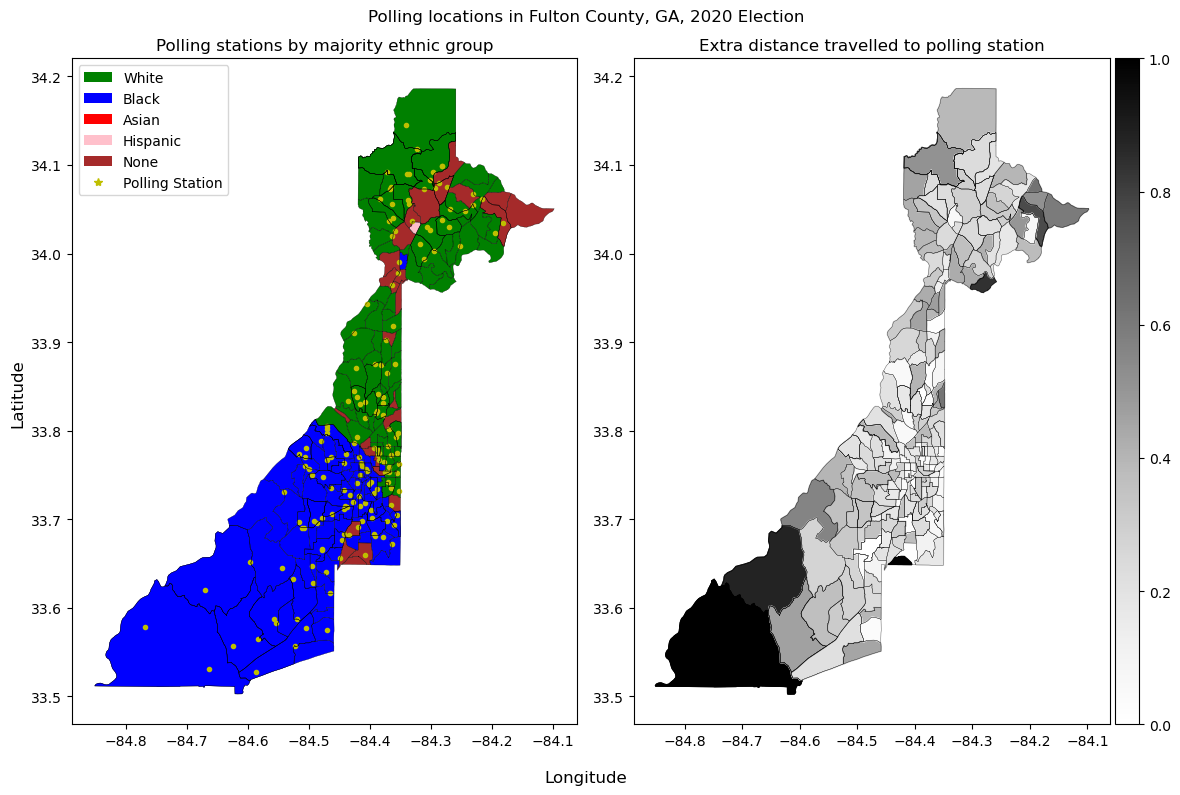

In [435]:
xmin, ymin, xmax, ymax = georgia[georgia['NAME']=='Fulton']['geometry'].total_bounds
fig, ax = plt.subplots(1,2, figsize=(12,8))

# Plotting polling station locations in Fulton county
for index in coords.index:
    point = Point(float(coords.loc[index, :]['lon']), float(coords.loc[index, :]['lat']))
    if georgia[georgia['NAME']=='Fulton']['geometry'].contains(point).values[0]:
        ax[0].plot(float(coords.loc[index, :]['lon']), float(coords.loc[index, :]['lat']),"y.")


station_counts = race_tracts['Polling Station Count'] / np.max(race_tracts['Polling Station Count'])

for i in range(race_tracts['geometry'].shape[0]):
    shape = race_tracts['geometry'][i]
    x,y = shape.exterior.xy
    ax[0].plot(x,y,'black', linewidth=0.2)
        
    # I can fill based on different values
    if race_tracts['Majority White'][i]==True:
        ax[0].fill(x,y, 'green')
    elif race_tracts['Majority Black'][i]==True:
        ax[0].fill(x,y, 'blue')
    elif race_tracts['Majority Asian'][i]==True:
        ax[0].fill(x,y, 'red')
    elif race_tracts['Majority Hispanic'][i]==True:
        ax[0].fill(x,y, 'pink')
    else:
        ax[0].fill(x,y, 'brown')
    ax[1].plot(x,y,'black', linewidth=0.2)
    fill_color = temporary_df['Total Distance per capita normalized'][i]
    if fill_color < 0:
        fill_color = 0
    ax[1].fill(x,y, color=(1-fill_color, \
                           1-fill_color, \
                           1-fill_color))

    
ax[0].fill([], 'green', label='White')
ax[0].fill([], 'blue', label='Black')
ax[0].fill([], 'red', label='Asian')
ax[0].fill([], 'pink', label='Hispanic')
ax[0].fill([], 'brown', label='None')
ax[0].plot([], 'y*', label='Polling Station')
ax[0].set_title("Polling stations by majority ethnic group")
ax[0].legend()

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)

ax[1].set_title("Extra distance travelled to polling station")
fig.suptitle("Polling locations in Fulton County, GA, 2020 Election")
fig.supxlabel("Longitude")
fig.supylabel("Latitude")

plt.colorbar(plt.cm.ScalarMappable(cmap='Greys'), cax=cax)
plt.tight_layout()
plt.show()

This converts to a max of 3.5 km of travel per person on average for the census tracts with the least access

In [151]:
radians_to_km(temporary_df.iloc[0:1]['Total Distance per capita'].astype(float), temporary_df.iloc[0:1]['lat'].astype(float))

0    0.087829
dtype: float64

In [152]:
111.11 * np.cos(temporary_df.iloc[0:1]['lat'].astype(float) / 180*np.pi) * temporary_df.iloc[0:1]['Total Distance per capita'].astype(float)

0    0.087829
dtype: float64

In [1157]:
(111.11*temporary_df['Total Distance per capita'].astype(float)*np.cos(temporary_df['lat'].astype(float) / 180*np.pi))\
.sort_values(ascending=False)

175    3.562991
174    3.561023
171    3.065636
170    3.064507
253    2.501927
         ...   
45     0.004937
130   -0.000152
196   -0.453939
195   -0.453947
247         NaN
Length: 259, dtype: float64

In [1161]:
(111.11*temporary_df_2016['Total Distance per capita'].astype(float)*np.cos(temporary_df_2016['lat'].astype(float) / 180*np.pi))\
.sort_values(ascending=False)

166    3.582362
165    3.580383
167    1.817493
163    1.708275
175    1.298529
         ...   
142    0.016113
64     0.015103
35     0.014189
190    0.007501
227         NaN
Length: 238, dtype: float64

In [154]:
np.max(111.11*temporary_df['Total Distance per capita'].astype(float)*np.cos(temporary_df['lat'].astype(float) / 180*np.pi))

3.5034337799532738

In [155]:
np.min(111.11*temporary_df['Total Distance per capita'].astype(float)*np.cos(temporary_df['lat'].astype(float) / 180*np.pi))

-0.4571754577655088

### 2022: Calculate distance travelled compared to centroid for each census tract

In [1109]:
poll_site_distances = []
i=0
# while i < race_tracts.shape[0]:

# i=239
while i < race_tracts_2022.shape[0]:
#     print(i)
    if i % 20 ==0:
        print(i)
    polygon = race_tracts_2022['geometry'][i]
    population = race_tracts_2022['population'][i]
    num_stations = int(race_tracts_2022['Polling Station Count'][i])
    tract = race_tracts_2022['Census Tract'][i]
    lat = []
    lon = []
    if num_stations > 1:
        for j in range(num_stations):
            lat.append(race_tracts_2022['lat'][i+j])
            lon.append(race_tracts_2022['lon'][i+j])
        i = i + num_stations - 1
    else:
        lat = [race_tracts_2022['lat'][i]]
        lon = [race_tracts_2022['lon'][i]]
    dist_to_poll = calculate_distance_to_poll(polygon, population, num_stations, lat, lon, race_tracts_2022, tract)
    poll_site_distances.append([tract, dist_to_poll])
    i = i +1

distance_df_2022 = pd.DataFrame(np.array(poll_site_distances))
distance_df_2022 = distance_df_2022.rename(columns={0:"Census Tract", 1: "Total Distance"})

0
20
40
60
100
120
140
160
220
240


In [1110]:
distance_df_2022

Census Tract      Total Distance
0        Census Tract 23   2.585827386176037
1        Census Tract 24  13.788685138440732
2        Census Tract 25   1.751848095285061
3        Census Tract 26   2.368678528935318
4        Census Tract 28  17.301808737649896
..                   ...                 ...
199  Census Tract 116.23  104.84703898106888
200  Census Tract 116.25  6.1507547351556155
201  Census Tract 116.26   35.07908127409382
202     Census Tract 118   8.299020537701029
203     Census Tract 119   8.093539851378537

[204 rows x 2 columns]

In [1111]:
temporary_df_2022 = race_tracts_2022.merge(distance_df_2022, how='left', on='Census Tract').fillna(-1000000)
temporary_df_2022['Normalized Total Distance'] = temporary_df_2022['Total Distance'].astype(float) / np.max(temporary_df_2022['Total Distance'].astype(float))
temporary_df_2022['Total Distance per capita'] = temporary_df_2022['Total Distance'].astype(float) / temporary_df_2022['population'].astype(float)
temporary_df_2022['Total Distance per capita normalized'] = temporary_df_2022['Total Distance per capita'] / np.max(temporary_df_2022['Total Distance per capita'])
temporary_df_2022['Total Distance per capita km'] = temporary_df_2022['Total Distance per capita'] * np.cos(temporary_df_2022['lat'].astype(float)/180*np.pi) * 111.11
temporary_df_2022

Census Tract                                           geometry  \
0        Census Tract 23  POLYGON ((-84.42117000008028 33.77139199981931...   
1        Census Tract 24  POLYGON ((-84.43353000026815 33.75552099982870...   
2        Census Tract 25  POLYGON ((-84.40783999982564 33.75636699972605...   
3        Census Tract 25  POLYGON ((-84.40783999982564 33.75636699972605...   
4        Census Tract 26  POLYGON ((-84.40203400024379 33.76342900017701...   
..                   ...                                                ...   
255  Census Tract 116.26  POLYGON ((-84.17773700018668 34.06952600000925...   
256  Census Tract 116.26  POLYGON ((-84.17773700018668 34.06952600000925...   
257  Census Tract 116.26  POLYGON ((-84.17773700018668 34.06952600000925...   
258     Census Tract 118  POLYGON ((-84.40818799952721 33.77455899977652...   
259     Census Tract 119  POLYGON ((-84.39324300026885 33.75460400016128...   

     population  Black   % Black  Majority Black  Asian   % Asian  \
0           891    774  0.868687            True      0  0.000000   
1          1825   1685  0.923288            True      0  0.000000   
2          1716   1531  0.892191            True     13  0.007576   
3          1716   1531  0.892191            True     13  0.007576   
4          1088   1019  0.936581            True     22  0.020221   
..          ...    ...       ...             ...    ...       ...   
255        6324    738  0.116698           False   1997  0.315781   
256        6324    738  0.116698           False   1997  0.315781   
257        6324    738  0.116698           False   1997  0.315781   
258        1741   1218  0.699598            True    151  0.086732   
259        2561   1247  0.486919           False    121  0.047247   

     Majority Asian  White  ...             lat             lon  \
0             False     98  ... -1000000.000000 -1000000.000000   
1             False    111  ... -1000000.000000 -1000000.000000   
2             False     89  ...       33.760259      -84.413143   
3             False     89  ...       33.763058      -84.413460   
4             False     14  ... -1000000.000000 -1000000.000000   
..              ...    ...  ...             ...             ...   
255           False   2965  ...       34.060934      -84.186471   
256           False   2965  ...       34.062026      -84.208695   
257           False   2965  ...       34.056127      -84.196479   
258           False    300  ... -1000000.000000 -1000000.000000   
259           False   1031  ...       33.753727      -84.374564   

     Polling Station Count  Polling Station Count per capita  \
0                      0.0                          0.000000   
1                      0.0                          0.000000   
2                      2.0                          0.001166   
3                      2.0                          0.001166   
4                      0.0                          0.000000   
..                     ...                               ...   
255                    3.0                          0.000474   
256                    3.0                          0.000474   
257                    3.0                          0.000474   
258                    0.0                          0.000000   
259                    1.0                          0.000390   

     Polling Station Count per capita normalized      Total Distance  \
0                                       0.000000   2.585827386176037   
1                                       0.000000  13.788685138440732   
2                                       0.744755   1.751848095285061   
3                                       0.744755   1.751848095285061   
4                                       0.000000   2.368678528935318   
..                                           ...                 ...   
255                                     0.303131   35.07908127409382   
256                                     0.303131   35.07908127409382   
257         

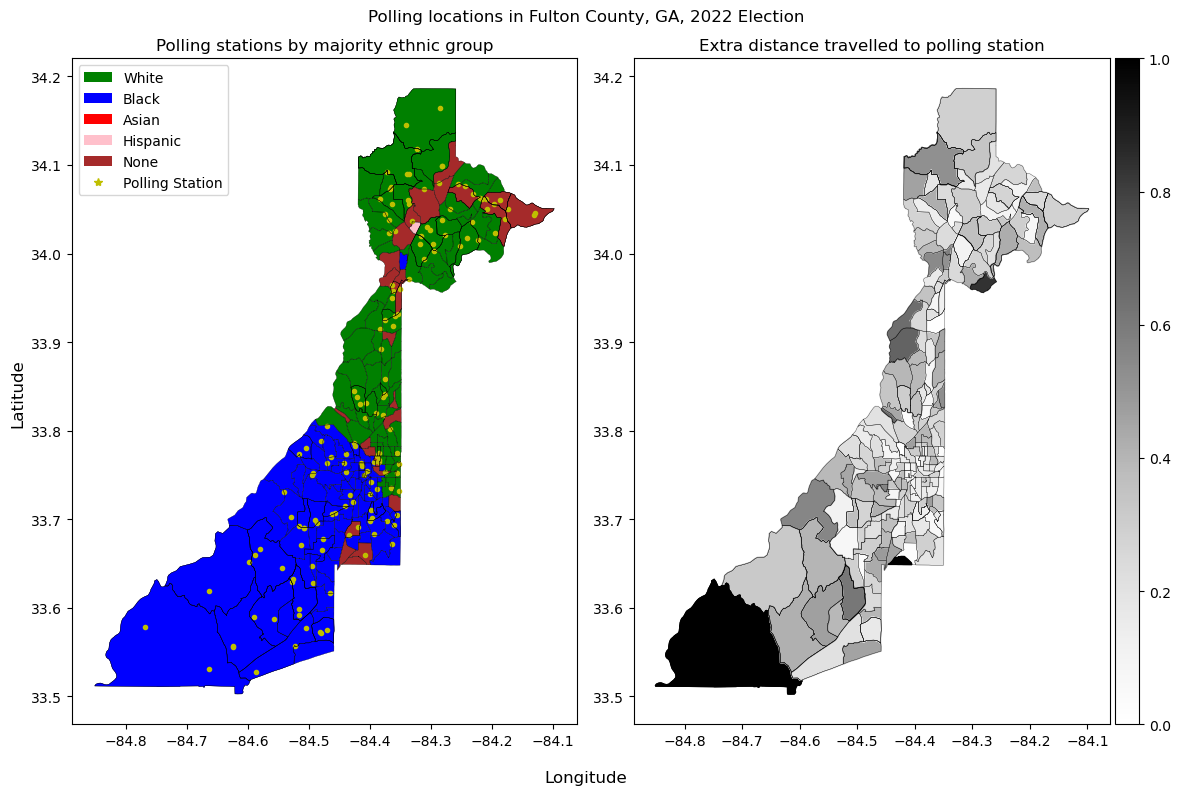

In [1113]:
xmin, ymin, xmax, ymax = georgia[georgia['NAME']=='Fulton']['geometry'].total_bounds
fig, ax = plt.subplots(1,2, figsize=(12,8))

# Plotting polling station locations in Fulton county
for index in coords_2022.index:
    point = Point(float(coords_2022.loc[index, :]['lon']), float(coords_2022.loc[index, :]['lat']))
    if georgia[georgia['NAME']=='Fulton']['geometry'].contains(point).values[0]:
        ax[0].plot(float(coords_2022.loc[index, :]['lon']), float(coords_2022.loc[index, :]['lat']),"y.")


# station_counts = race_tracts['Polling Station Count'] / np.max(race_tracts['Polling Station Count'])

for i in range(race_tracts_2022['geometry'].shape[0]):
    shape = race_tracts_2022['geometry'][i]
    x,y = shape.exterior.xy
    ax[0].plot(x,y,'black', linewidth=0.2)
        
    # I can fill based on different values
    if race_tracts_2022['Majority White'][i]==True:
        ax[0].fill(x,y, 'green')
    elif race_tracts_2022['Majority Black'][i]==True:
        ax[0].fill(x,y, 'blue')
    elif race_tracts_2022['Majority Asian'][i]==True:
        ax[0].fill(x,y, 'red')
    elif race_tracts_2022['Majority Hispanic'][i]==True:
        ax[0].fill(x,y, 'pink')
    else:
        ax[0].fill(x,y, 'brown')
    ax[1].plot(x,y,'black', linewidth=0.2)
    fill_color = temporary_df_2022['Total Distance per capita normalized'][i]
    if fill_color < 0:
        fill_color = 0
    ax[1].fill(x,y, color=(1-fill_color, \
                           1-fill_color, \
                           1-fill_color))

    
ax[0].fill([], 'green', label='White')
ax[0].fill([], 'blue', label='Black')
ax[0].fill([], 'red', label='Asian')
ax[0].fill([], 'pink', label='Hispanic')
ax[0].fill([], 'brown', label='None')
ax[0].plot([], 'y*', label='Polling Station')
ax[0].set_title("Polling stations by majority ethnic group")
ax[0].legend()

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)

ax[1].set_title("Extra distance travelled to polling station")
fig.suptitle("Polling locations in Fulton County, GA, 2022 Election")
fig.supxlabel("Longitude")
fig.supylabel("Latitude")

plt.colorbar(plt.cm.ScalarMappable(cmap='Greys'), cax=cax)
plt.tight_layout()
plt.show()

### 2018: Calculate distance travelled compared to centroid for each census tract

In [961]:
# DATA FRAME FOR FULTON COUNTY ANALYSIS

# Merging race data and shape data
race_tracts_2018 = fulton_tracts.merge(fulton_race_2, left_on='geoid10', right_on='GEOID')
race_tracts_2018 = race_tracts_2018.rename(columns={"Ages1664_e18":"population", \
                                         "Black1664_e18": "Black", \
                                         "Asian1664_e18": "Asian", \
                                         "NHWhite1664_e18": "White", \
                                         "Hispanic1664_e18": "Hispanic",\
                                         "mMedBlackHHInc_e18": "Median Black Household Income", \
                                         "mMedAsianHHInc_e18": "Median Asian Household Income", \
                                         "mMedNHWhiteHHInc_e18": "Median White Household Income", \
                                         "mMedHispHHInc_e18": "Median Hispanic Household Income", \
                                         "SHAPE_Length": "Length", \
                                         "SHAPE_Area": "Area", \
                                         "NAME": "Census Tract", \
                                         })

race_tracts_2018['% White'] = race_tracts_2018['White'] / race_tracts_2018['population']
race_tracts_2018['% Black'] = race_tracts_2018['Black'] / race_tracts_2018['population']
race_tracts_2018['% Asian'] = race_tracts_2018['Asian'] / race_tracts_2018['population']
race_tracts_2018['% Hispanic'] = race_tracts_2018['Hispanic'] / race_tracts_2018['population']
race_tracts_2018['Majority Black'] = race_tracts_2018['% Black'] > 0.50
race_tracts_2018['Majority Asian'] = race_tracts_2018['% Asian'] > 0.50
race_tracts_2018['Majority White'] = race_tracts_2018['% White'] > 0.50
race_tracts_2018['Majority Hispanic'] = race_tracts_2018['% Hispanic'] > 0.50


race_tracts_2018 = race_tracts_2018.loc[:, ['Census Tract', \
                    'geometry', \
                    'population', \
                    'Black', \
                    '% Black', \
                    'Majority Black', \
                    'Asian', \
                    '% Asian', \
                    'Majority Asian', \
                    'White', \
                    '% White', \
                    'Majority White', \
                    'Hispanic', \
                    '% Hispanic', \
                    'Majority Hispanic', \
                    'Median Black Household Income', \
                    'Median Asian Household Income', \
                    'Median White Household Income', \
                    'Median Hispanic Household Income', \
                    'Length', \
                    'areaac', \
                    'Area']]

race_tracts_2018['pop_area'] = race_tracts_2018['population'] / race_tracts_2018['Area']
race_tracts_2018['normalized_pop'] = race_tracts_2018['pop_area'] / np.max(race_tracts_2018['pop_area'])

In [962]:
race_tracts_2018 = race_tracts_2018.merge(coords_2018, how='left', on='Census Tract')

In [963]:
# Identifying number of polling stations in each census tract
station_count = coords_2018.groupby('Census Tract')['lat'].count().to_frame().rename(columns={'lat': 'Polling Station Count'})

In [964]:
# Merging polling station count info with full df
race_tracts_2018 = race_tracts_2018.merge(station_count, how='left', on='Census Tract')
race_tracts_2018['Polling Station Count'] = race_tracts_2018['Polling Station Count'].to_frame().fillna(0)
race_tracts_2018

Census Tract  \
0        Census Tract 23, Fulton County   
1        Census Tract 24, Fulton County   
2        Census Tract 25, Fulton County   
3        Census Tract 25, Fulton County   
4        Census Tract 26, Fulton County   
..                                  ...   
225  Census Tract 116.23, Fulton County   
226  Census Tract 116.25, Fulton County   
227  Census Tract 116.26, Fulton County   
228     Census Tract 118, Fulton County   
229     Census Tract 119, Fulton County   

                                              geometry  population  Black  \
0    POLYGON ((-84.42117000008028 33.77139199981931...         891    774   
1    POLYGON ((-84.43353000026815 33.75552099982870...        1825   1685   
2    POLYGON ((-84.40783999982564 33.75636699972605...        1716   1531   
3    POLYGON ((-84.40783999982564 33.75636699972605...        1716   1531   
4    POLYGON ((-84.40203400024379 33.76342900017701...        1088   1019   
..                                                 ...         ...    ...   
225  POLYGON ((-84.2104260000742 34.04793100023602,...        8714    888   
226  POLYGON ((-84.20987999953815 34.04531199966071...        5354    526   
227  POLYGON ((-84.17773700018668 34.06952600000925...        6324    738   
228  POLYGON ((-84.40818799952721 33.77455899977652...        1741   1218   
229  POLYGON ((-84.39324300026885 33.75460400016128...        2561   1247   

      % Black  Majority Black  Asian   % Asian  Majority Asian  White  ...  \
0    0.868687            True      0  0.000000           False     98  ...   
1    0.923288            True      0  0.000000           False    111  ...   
2    0.892191            True     13  0.007576           False     89  ...   
3    0.892191            True     13  0.007576           False     89  ...   
4    0.936581            True     22  0.020221           False     14  ...   
..        ...             ...    ...       ...             ...    ...  ...   
225  0.101905           False   3445  0.395341           False   3630  ...   
226  0.098244           False   1534  0.286515           False   2853  ...   
227  0.116698           False   1997  0.315781           False   2965  ...   
228  0.699598            True    151  0.086732           False    300  ...   
229  0.486919           False    121  0.047247           False   1031  ...   

     Median White Household Income  Median Hispanic Household Income  \
0                              NaN                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   
3                              NaN                               NaN   
4                              NaN                               NaN   
..                             ...                               ...   
225                       117968.0                           54760.0   
226                       106932.0                           61051.0   
227                        95083.0                          100472.0   
228                         2499.0                           40417.0   
229                        52917.0                               NaN   

       Length         areaac      Area      pop_area  normalized_pop  \
0    0.051850   277.33258157  0.000109  8.155651e+06        0.090671   
1    0.050614   334.08361991  0.000132  1.386859e+07        0.154186   
2    0.036889   215.48088541  0.000085  2.021765e+07        0.224772   
3    0.036889   215.48088541  0.000085  2.021765e+07        0.224772   
4    0.039820   236.16208858  0.000093  1.169612e+07        0.130033   
..        ...            ...       ...           ...             ...   
225  0.188553  2299.71906461  0.000909  9.588637e+06        0.106603   
226  0.137991  1507.59255431  0.000596  8.988020e+06        0.099925   
227  0.110421   1432.5315835  0.000566  1.116842e+07        0.124166   
228  0.069066   462.01757011  0.000182  9.565405e+06        0.1

In [965]:
race_tracts_2018['Polling Station Count per capita'] = race_tracts_2018['Polling Station Count'] / race_tracts_2018['population']
race_tracts_2018['Polling Station Count per capita normalized'] = race_tracts_2018['Polling Station Count per capita'] / np.max(race_tracts_2018['Polling Station Count per capita'])

In [966]:
poll_site_distances = []
i=0
# while i < race_tracts.shape[0]:

# i=239
while i < race_tracts_2018.shape[0]:
#     print(i)
    if i % 20 ==0:
        print(i)
    polygon = race_tracts_2018['geometry'][i]
    population = race_tracts_2018['population'][i]
    num_stations = int(race_tracts_2018['Polling Station Count'][i])
    tract = race_tracts_2018['Census Tract'][i]
    lat = []
    lon = []
    if num_stations > 1:
        for j in range(num_stations):
            lat.append(race_tracts_2018['lat'][i+j])
            lon.append(race_tracts_2018['lon'][i+j])
        i = i + num_stations - 1
    else:
        lat = [race_tracts_2018['lat'][i]]
        lon = [race_tracts_2018['lon'][i]]
    dist_to_poll = calculate_distance_to_poll(polygon, population, num_stations, lat, lon, race_tracts_2018, tract)
    poll_site_distances.append([tract, dist_to_poll])
    i = i +1

distance_df_2018 = pd.DataFrame(np.array(poll_site_distances))
distance_df_2018 = distance_df_2018.rename(columns={0:"Census Tract", 1: "Total Distance"})

0
20
40
60
80
100
120
140
180
200


In [967]:
distance_df_2018

Census Tract      Total Distance
0        Census Tract 23, Fulton County  0.8387952790142679
1        Census Tract 24, Fulton County   5.711775541838721
2        Census Tract 25, Fulton County  1.8505125638625821
3        Census Tract 26, Fulton County  2.2580109490870535
4        Census Tract 28, Fulton County   17.23214772133401
..                                  ...                 ...
199  Census Tract 116.23, Fulton County   238.0753961329256
200  Census Tract 116.25, Fulton County  49.421886294785054
201  Census Tract 116.26, Fulton County  108.03943184557946
202     Census Tract 118, Fulton County   5.934601277713259
203     Census Tract 119, Fulton County   8.001394805242114

[204 rows x 2 columns]

In [968]:
temporary_df_2018 = race_tracts_2018.merge(distance_df_2018, how='left', on='Census Tract').fillna(-1000000)
temporary_df_2018['Normalized Total Distance'] = temporary_df_2018['Total Distance'].astype(float) / np.max(temporary_df_2018['Total Distance'].astype(float))
temporary_df_2018['Total Distance per capita'] = temporary_df_2018['Total Distance'].astype(float) / temporary_df_2018['population'].astype(float)
temporary_df_2018['Total Distance per capita normalized'] = temporary_df_2018['Total Distance per capita'] / np.max(temporary_df_2018['Total Distance per capita'])
temporary_df_2018['Total Distance per capita km'] = temporary_df_2018['Total Distance per capita'] * np.cos(temporary_df_2018['lat'].astype(float)/180*np.pi) * 111.11
temporary_df_2018

Census Tract  \
0        Census Tract 23, Fulton County   
1        Census Tract 24, Fulton County   
2        Census Tract 25, Fulton County   
3        Census Tract 25, Fulton County   
4        Census Tract 26, Fulton County   
..                                  ...   
225  Census Tract 116.23, Fulton County   
226  Census Tract 116.25, Fulton County   
227  Census Tract 116.26, Fulton County   
228     Census Tract 118, Fulton County   
229     Census Tract 119, Fulton County   

                                              geometry  population  Black  \
0    POLYGON ((-84.42117000008028 33.77139199981931...         891    774   
1    POLYGON ((-84.43353000026815 33.75552099982870...        1825   1685   
2    POLYGON ((-84.40783999982564 33.75636699972605...        1716   1531   
3    POLYGON ((-84.40783999982564 33.75636699972605...        1716   1531   
4    POLYGON ((-84.40203400024379 33.76342900017701...        1088   1019   
..                                                 ...         ...    ...   
225  POLYGON ((-84.2104260000742 34.04793100023602,...        8714    888   
226  POLYGON ((-84.20987999953815 34.04531199966071...        5354    526   
227  POLYGON ((-84.17773700018668 34.06952600000925...        6324    738   
228  POLYGON ((-84.40818799952721 33.77455899977652...        1741   1218   
229  POLYGON ((-84.39324300026885 33.75460400016128...        2561   1247   

      % Black  Majority Black  Asian   % Asian  Majority Asian  White  ...  \
0    0.868687            True      0  0.000000           False     98  ...   
1    0.923288            True      0  0.000000           False    111  ...   
2    0.892191            True     13  0.007576           False     89  ...   
3    0.892191            True     13  0.007576           False     89  ...   
4    0.936581            True     22  0.020221           False     14  ...   
..        ...             ...    ...       ...             ...    ...  ...   
225  0.101905           False   3445  0.395341           False   3630  ...   
226  0.098244           False   1534  0.286515           False   2853  ...   
227  0.116698           False   1997  0.315781           False   2965  ...   
228  0.699598            True    151  0.086732           False    300  ...   
229  0.486919           False    121  0.047247           False   1031  ...   

                lat             lon  Polling Station Count  \
0         33.769778      -84.416820                    1.0   
1   -1000000.000000 -1000000.000000                    0.0   
2         33.760259      -84.413143                    2.0   
3         33.763058      -84.413460                    2.0   
4   -1000000.000000 -1000000.000000                    0.0   
..              ...             ...                    ...   
225       34.034914      -84.181616                    2.0   
226 -1000000.000000 -1000000.000000                    0.0   
227 -1000000.000000 -1000000.000000                    0.0   
228 -1000000.000000 -1000000.000000                    0.0   
229       33.753727      -84.374564                    1.0   

     Polling Station Count per capita  \
0                            0.001122   
1                            0.000000   
2                            0.001166   
3                            0.001166   
4                            0.000000   
..                                ...   
225                          0.000230   
226                          0.000000   
227                          0.000000   
228                          0.000000   
229                          0.000390   

     Polling Station Count per capita normalized      Total Distance  \
0                                       0.482978  0.8387952790142679   
1                                       0.000000   5.711775541838721   
2                                       0.501554  1.8505125638625821   
3                                       0.501554  1.8505125638625821   
4                                       0.000000  

In [969]:
temporary_df_2018.head()

Census Tract  \
0  Census Tract 23, Fulton County   
1  Census Tract 24, Fulton County   
2  Census Tract 25, Fulton County   
3  Census Tract 25, Fulton County   
4  Census Tract 26, Fulton County   

                                            geometry  population  Black  \
0  POLYGON ((-84.42117000008028 33.77139199981931...         891    774   
1  POLYGON ((-84.43353000026815 33.75552099982870...        1825   1685   
2  POLYGON ((-84.40783999982564 33.75636699972605...        1716   1531   
3  POLYGON ((-84.40783999982564 33.75636699972605...        1716   1531   
4  POLYGON ((-84.40203400024379 33.76342900017701...        1088   1019   

    % Black  Majority Black  Asian   % Asian  Majority Asian  White  ...  \
0  0.868687            True      0  0.000000           False     98  ...   
1  0.923288            True      0  0.000000           False    111  ...   
2  0.892191            True     13  0.007576           False     89  ...   
3  0.892191            True     13  0.007576           False     89  ...   
4  0.936581            True     22  0.020221           False     14  ...   

              lat             lon  Polling Station Count  \
0       33.769778      -84.416820                    1.0   
1 -1000000.000000 -1000000.000000                    0.0   
2       33.760259      -84.413143                    2.0   
3       33.763058      -84.413460                    2.0   
4 -1000000.000000 -1000000.000000                    0.0   

   Polling Station Count per capita  \
0                          0.001122   
1                          0.000000   
2                          0.001166   
3                          0.001166   
4                          0.000000   

   Polling Station Count per capita normalized      Total Distance  \
0                                     0.482978  0.8387952790142679   
1                                     0.000000   5.711775541838721   
2                                     0.501554  1.8505125638625821   
3                                     0.501554  1.8505125638625821   
4                                     0.000000  2.2580109490870535   

   Normalized Total Distance  Total Distance per capita  \
0                   0.002158                   0.000941   
1                   0.014695                   0.003130   
2                   0.004761                   0.001078   
3                   0.004761                   0.001078   
4                   0.005809                   0.002075   

   Total Distance per capita normalized  Total Distance per capita km  
0                              0.024831                      0.086952  
1                              0.082550                      0.060385  
2                              0.028444                      0.099614  
3                              0.028444                      0.099611  
4                              0.054740                      0.040042  

[5 rows x 34 columns]

In [970]:
coords_2018.shape

(123, 3)

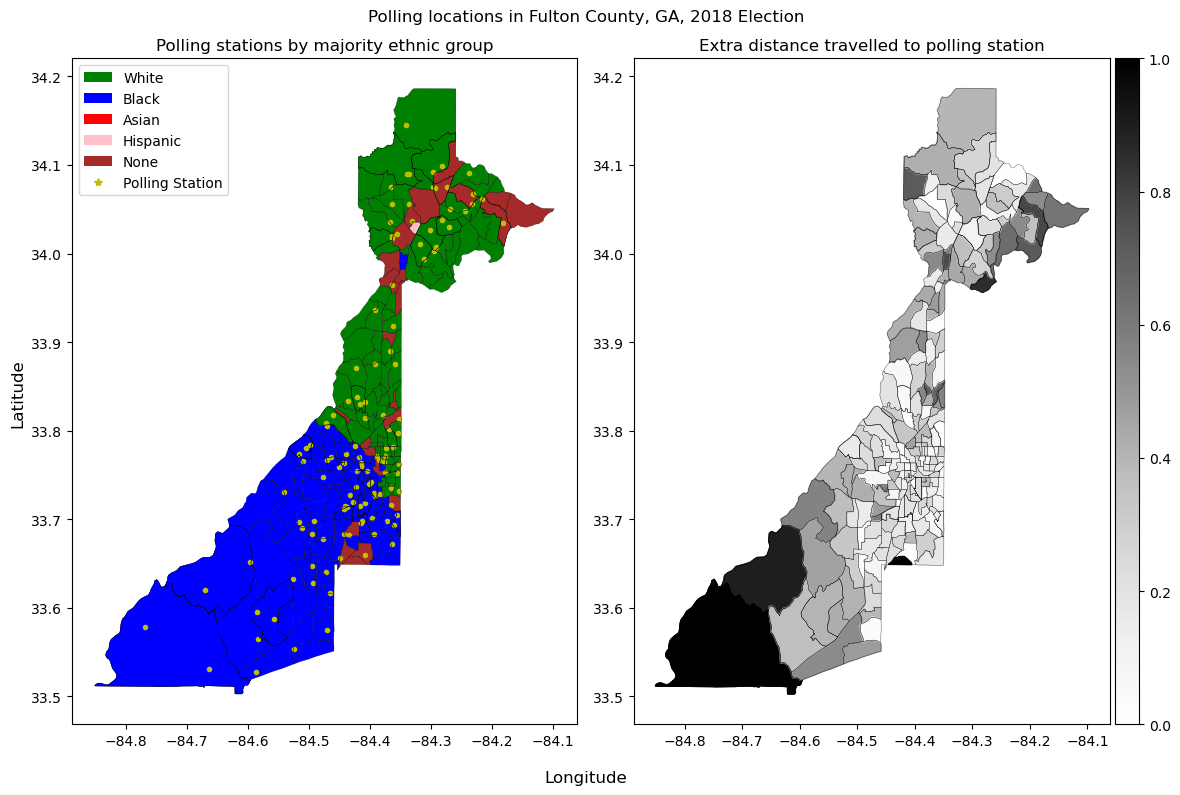

In [971]:
xmin, ymin, xmax, ymax = georgia[georgia['NAME']=='Fulton']['geometry'].total_bounds
fig, ax = plt.subplots(1,2, figsize=(12,8))

# Plotting polling station locations in Fulton county
for index in coords_2018.index:
    point = Point(float(coords_2018.loc[index, :]['lon']), float(coords_2018.loc[index, :]['lat']))
    if georgia[georgia['NAME']=='Fulton']['geometry'].contains(point).values[0]:
        ax[0].plot(float(coords_2018.loc[index, :]['lon']), float(coords_2018.loc[index, :]['lat']),"y.")


# station_counts = race_tracts['Polling Station Count'] / np.max(race_tracts['Polling Station Count'])

for i in range(race_tracts_2018['geometry'].shape[0]):
    shape = race_tracts_2018['geometry'][i]
    x,y = shape.exterior.xy
    ax[0].plot(x,y,'black', linewidth=0.2)
        
    # I can fill based on different values
    if race_tracts_2018['Majority White'][i]==True:
        ax[0].fill(x,y, 'green')
    elif race_tracts_2018['Majority Black'][i]==True:
        ax[0].fill(x,y, 'blue')
    elif race_tracts_2018['Majority Asian'][i]==True:
        ax[0].fill(x,y, 'red')
    elif race_tracts_2018['Majority Hispanic'][i]==True:
        ax[0].fill(x,y, 'pink')
    else:
        ax[0].fill(x,y, 'brown')
    ax[1].plot(x,y,'black', linewidth=0.2)
    fill_color = temporary_df_2018['Total Distance per capita normalized'][i]
    if fill_color < 0:
        fill_color = 0
    ax[1].fill(x,y, color=(1-fill_color, \
                           1-fill_color, \
                           1-fill_color))

    
ax[0].fill([], 'green', label='White')
ax[0].fill([], 'blue', label='Black')
ax[0].fill([], 'red', label='Asian')
ax[0].fill([], 'pink', label='Hispanic')
ax[0].fill([], 'brown', label='None')
ax[0].plot([], 'y*', label='Polling Station')
ax[0].set_title("Polling stations by majority ethnic group")
ax[0].legend()

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)

ax[1].set_title("Extra distance travelled to polling station")
fig.suptitle("Polling locations in Fulton County, GA, 2018 Election")
fig.supxlabel("Longitude")
fig.supylabel("Latitude")

plt.colorbar(plt.cm.ScalarMappable(cmap='Greys'), cax=cax)
plt.tight_layout()
plt.show()

### 2016: Calculate distance travelled compared to centroid for each census tract

In [975]:
# DATA FRAME FOR FULTON COUNTY ANALYSIS

# Merging race data and shape data
race_tracts_2016 = fulton_tracts.merge(fulton_race_2, left_on='geoid10', right_on='GEOID')
race_tracts_2016 = race_tracts_2016.rename(columns={"Ages1664_e18":"population", \
                                         "Black1664_e18": "Black", \
                                         "Asian1664_e18": "Asian", \
                                         "NHWhite1664_e18": "White", \
                                         "Hispanic1664_e18": "Hispanic",\
                                         "mMedBlackHHInc_e18": "Median Black Household Income", \
                                         "mMedAsianHHInc_e18": "Median Asian Household Income", \
                                         "mMedNHWhiteHHInc_e18": "Median White Household Income", \
                                         "mMedHispHHInc_e18": "Median Hispanic Household Income", \
                                         "SHAPE_Length": "Length", \
                                         "SHAPE_Area": "Area", \
                                         "NAME": "Census Tract", \
                                         })

race_tracts_2016['% White'] = race_tracts_2016['White'] / race_tracts_2018['population']
race_tracts_2016['% Black'] = race_tracts_2016['Black'] / race_tracts_2018['population']
race_tracts_2016['% Asian'] = race_tracts_2016['Asian'] / race_tracts_2018['population']
race_tracts_2016['% Hispanic'] = race_tracts_2016['Hispanic'] / race_tracts_2018['population']
race_tracts_2016['Majority Black'] = race_tracts_2016['% Black'] > 0.50
race_tracts_2016['Majority Asian'] = race_tracts_2016['% Asian'] > 0.50
race_tracts_2016['Majority White'] = race_tracts_2016['% White'] > 0.50
race_tracts_2016['Majority Hispanic'] = race_tracts_2016['% Hispanic'] > 0.50


race_tracts_2016 = race_tracts_2016.loc[:, ['Census Tract', \
                    'geometry', \
                    'population', \
                    'Black', \
                    '% Black', \
                    'Majority Black', \
                    'Asian', \
                    '% Asian', \
                    'Majority Asian', \
                    'White', \
                    '% White', \
                    'Majority White', \
                    'Hispanic', \
                    '% Hispanic', \
                    'Majority Hispanic', \
                    'Median Black Household Income', \
                    'Median Asian Household Income', \
                    'Median White Household Income', \
                    'Median Hispanic Household Income', \
                    'Length', \
                    'areaac', \
                    'Area']]

race_tracts_2016['pop_area'] = race_tracts_2016['population'] / race_tracts_2018['Area']
race_tracts_2016['normalized_pop'] = race_tracts_2016['pop_area'] / np.max(race_tracts_2018['pop_area'])

In [989]:
race_tracts_2016 = race_tracts_2016.merge(coords_2016, how='left', on='Census Tract')

In [990]:
# # Identifying number of polling stations in each census tract
station_count = coords_2016.groupby('Census Tract')['lat'].count().to_frame().rename(columns={'lat': 'Polling Station Count'})

In [991]:
# Merging polling station count info with full df
race_tracts_2016 = race_tracts_2016.merge(station_count, how='left', on='Census Tract')
race_tracts_2016['Polling Station Count'] = race_tracts_2016['Polling Station Count'].to_frame().fillna(0)
race_tracts_2016

Census Tract  \
0        Census Tract 23, Fulton County   
1        Census Tract 24, Fulton County   
2        Census Tract 25, Fulton County   
3        Census Tract 25, Fulton County   
4        Census Tract 26, Fulton County   
..                                  ...   
233  Census Tract 116.23, Fulton County   
234  Census Tract 116.25, Fulton County   
235  Census Tract 116.26, Fulton County   
236     Census Tract 118, Fulton County   
237     Census Tract 119, Fulton County   

                                              geometry  population  Black  \
0    POLYGON ((-84.42117000008028 33.77139199981931...         891    774   
1    POLYGON ((-84.43353000026815 33.75552099982870...        1825   1685   
2    POLYGON ((-84.40783999982564 33.75636699972605...        1716   1531   
3    POLYGON ((-84.40783999982564 33.75636699972605...        1716   1531   
4    POLYGON ((-84.40203400024379 33.76342900017701...        1088   1019   
..                                                 ...         ...    ...   
233  POLYGON ((-84.2104260000742 34.04793100023602,...        8714    888   
234  POLYGON ((-84.20987999953815 34.04531199966071...        5354    526   
235  POLYGON ((-84.17773700018668 34.06952600000925...        6324    738   
236  POLYGON ((-84.40818799952721 33.77455899977652...        1741   1218   
237  POLYGON ((-84.39324300026885 33.75460400016128...        2561   1247   

      % Black  Majority Black  Asian   % Asian  Majority Asian  White  ...  \
0    0.868687            True      0  0.000000           False     98  ...   
1    0.923288            True      0  0.000000           False    111  ...   
2    0.892191            True     13  0.007576           False     89  ...   
3    0.892191            True     13  0.007576           False     89  ...   
4    0.593823            True     22  0.012821           False     14  ...   
..        ...             ...    ...       ...             ...    ...  ...   
233  0.172461           False   3445  0.669062            True   3630  ...   
234  0.076632           False   1534  0.223485           False   2853  ...   
235  0.107517           False   1997  0.290938           False   2965  ...   
236  0.137363           False    151  0.017029           False    300  ...   
237  0.446473           False    121  0.043323           False   1031  ...   

     Median White Household Income  Median Hispanic Household Income  \
0                              NaN                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   
3                              NaN                               NaN   
4                              NaN                               NaN   
..                             ...                               ...   
233                       117968.0                           54760.0   
234                       106932.0                           61051.0   
235                        95083.0                          100472.0   
236                         2499.0                           40417.0   
237                        52917.0                               NaN   

       Length         areaac      Area      pop_area  normalized_pop  \
0    0.051850   277.33258157  0.000109  8.155651e+06        0.090671   
1    0.050614   334.08361991  0.000132  1.386859e+07        0.154186   
2    0.036889   215.48088541  0.000085  2.021765e+07        0.224772   
3    0.036889   215.48088541  0.000085  2.021765e+07        0.224772   
4    0.039820   236.16208858  0.000093  1.281865e+07        0.142513   
..        ...            ...       ...           ...             ...   
233  0.188553  2299.71906461  0.000909  1.275115e+07        0.141762   
234  0.137991  1507.59255431  0.000596  1.763460e+06        0.019605   
235  0.110421   1432.5315835  0.000566  2.082951e+06        0.023157   
236  0.069066   462.01757011  0.000182  2.996208e+05        0.0

In [992]:
race_tracts_2016['Polling Station Count per capita'] = race_tracts_2016['Polling Station Count'] / race_tracts_2016['population']
race_tracts_2016['Polling Station Count per capita normalized'] = race_tracts_2016['Polling Station Count per capita'] / np.max(race_tracts_2016['Polling Station Count per capita'])

In [993]:
poll_site_distances = []
i=0
# while i < race_tracts.shape[0]:

# i=239
while i < race_tracts_2016.shape[0]:
#     print(i)
    if i % 20 ==0:
        print(i)
    polygon = race_tracts_2016['geometry'][i]
    population = race_tracts_2016['population'][i]
    num_stations = int(race_tracts_2016['Polling Station Count'][i])
    tract = race_tracts_2016['Census Tract'][i]
    lat = []
    lon = []
    if num_stations > 1:
        for j in range(num_stations):
            lat.append(race_tracts_2016['lat'][i+j])
            lon.append(race_tracts_2016['lon'][i+j])
        i = i + num_stations - 1
    else:
        lat = [race_tracts_2016['lat'][i]]
        lon = [race_tracts_2016['lon'][i]]
    dist_to_poll = calculate_distance_to_poll(polygon, population, num_stations, lat, lon, race_tracts_2016, tract)
    poll_site_distances.append([tract, dist_to_poll])
    i = i +1

distance_df_2016 = pd.DataFrame(np.array(poll_site_distances))
distance_df_2016 = distance_df_2016.rename(columns={0:"Census Tract", 1: "Total Distance"})

0
20
40
60
100
120
140
160
180
200
220


In [996]:
distance_df_2016

Census Tract      Total Distance
0        Census Tract 23, Fulton County  0.8843204989179219
1        Census Tract 24, Fulton County  13.505624520162366
2        Census Tract 25, Fulton County   1.812466582117421
3        Census Tract 26, Fulton County  2.3892731761832655
4        Census Tract 28, Fulton County   11.04584714159654
..                                  ...                 ...
199  Census Tract 116.23, Fulton County   6.340604764440258
200  Census Tract 116.25, Fulton County   48.79565014305196
201  Census Tract 116.26, Fulton County  118.01211741359823
202     Census Tract 118, Fulton County   6.040634317967342
203     Census Tract 119, Fulton County   8.147205865925546

[204 rows x 2 columns]

In [997]:
temporary_df_2016 = race_tracts_2016.merge(distance_df_2016, how='left', on='Census Tract').fillna(-1000000)
temporary_df_2016['Normalized Total Distance'] = temporary_df_2016['Total Distance'].astype(float) / np.max(temporary_df_2016['Total Distance'].astype(float))
temporary_df_2016['Total Distance per capita'] = temporary_df_2016['Total Distance'].astype(float) / temporary_df_2016['population'].astype(float)
temporary_df_2016['Total Distance per capita normalized'] = temporary_df_2016['Total Distance per capita'] / np.max(temporary_df_2016['Total Distance per capita'])
temporary_df_2016['Total Distance per capita km'] = temporary_df_2016['Total Distance per capita'] * np.cos(temporary_df_2016['lat'].astype(float)/180*np.pi) * 111.11
temporary_df_2016

Census Tract  \
0        Census Tract 23, Fulton County   
1        Census Tract 24, Fulton County   
2        Census Tract 25, Fulton County   
3        Census Tract 25, Fulton County   
4        Census Tract 26, Fulton County   
..                                  ...   
233  Census Tract 116.23, Fulton County   
234  Census Tract 116.25, Fulton County   
235  Census Tract 116.26, Fulton County   
236     Census Tract 118, Fulton County   
237     Census Tract 119, Fulton County   

                                              geometry  population  Black  \
0    POLYGON ((-84.42117000008028 33.77139199981931...         891    774   
1    POLYGON ((-84.43353000026815 33.75552099982870...        1825   1685   
2    POLYGON ((-84.40783999982564 33.75636699972605...        1716   1531   
3    POLYGON ((-84.40783999982564 33.75636699972605...        1716   1531   
4    POLYGON ((-84.40203400024379 33.76342900017701...        1088   1019   
..                                                 ...         ...    ...   
233  POLYGON ((-84.2104260000742 34.04793100023602,...        8714    888   
234  POLYGON ((-84.20987999953815 34.04531199966071...        5354    526   
235  POLYGON ((-84.17773700018668 34.06952600000925...        6324    738   
236  POLYGON ((-84.40818799952721 33.77455899977652...        1741   1218   
237  POLYGON ((-84.39324300026885 33.75460400016128...        2561   1247   

      % Black  Majority Black  Asian   % Asian  Majority Asian  White  ...  \
0    0.868687            True      0  0.000000           False     98  ...   
1    0.923288            True      0  0.000000           False    111  ...   
2    0.892191            True     13  0.007576           False     89  ...   
3    0.892191            True     13  0.007576           False     89  ...   
4    0.593823            True     22  0.012821           False     14  ...   
..        ...             ...    ...       ...             ...    ...  ...   
233  0.172461           False   3445  0.669062            True   3630  ...   
234  0.076632           False   1534  0.223485           False   2853  ...   
235  0.107517           False   1997  0.290938           False   2965  ...   
236  0.137363           False    151  0.017029           False    300  ...   
237  0.446473           False    121  0.043323           False   1031  ...   

                lat             lon  Polling Station Count  \
0         33.769778      -84.416820                    1.0   
1   -1000000.000000 -1000000.000000                    0.0   
2         33.760259      -84.413143                    2.0   
3         33.763058      -84.413460                    2.0   
4   -1000000.000000 -1000000.000000                    0.0   
..              ...             ...                    ...   
233       34.034914      -84.181616                    1.0   
234 -1000000.000000 -1000000.000000                    0.0   
235 -1000000.000000 -1000000.000000                    0.0   
236 -1000000.000000 -1000000.000000                    0.0   
237       33.753727      -84.374564                    1.0   

     Polling Station Count per capita  \
0                            0.001122   
1                            0.000000   
2                            0.001166   
3                            0.001166   
4                            0.000000   
..                                ...   
233                          0.000115   
234                          0.000000   
235                          0.000000   
236                          0.000000   
237                          0.000390   

     Polling Station Count per capita normalized      Total Distance  \
0                                       0.362233  0.8843204989179219   
1                                       0.000000  13.505624520162366   
2                                       0.376166   1.812466582117421   
3                                       0.376166   1.812466582117421   
4                                       0.000000  

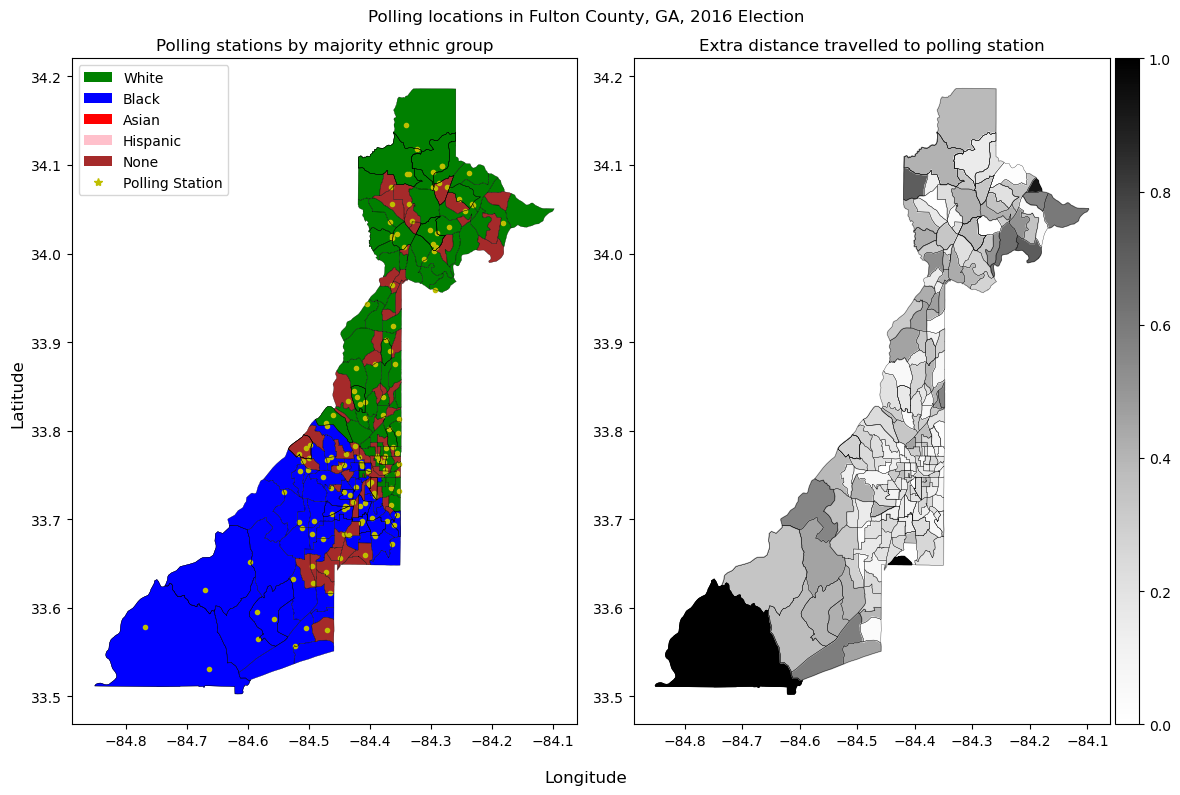

In [999]:
xmin, ymin, xmax, ymax = georgia[georgia['NAME']=='Fulton']['geometry'].total_bounds
fig, ax = plt.subplots(1,2, figsize=(12,8))

# Plotting polling station locations in Fulton county
for index in coords_2016.index:
    point = Point(float(coords_2016.loc[index, :]['lon']), float(coords_2016.loc[index, :]['lat']))
    if georgia[georgia['NAME']=='Fulton']['geometry'].contains(point).values[0]:
        ax[0].plot(float(coords_2016.loc[index, :]['lon']), float(coords_2016.loc[index, :]['lat']),"y.")


# station_counts = race_tracts['Polling Station Count'] / np.max(race_tracts['Polling Station Count'])

for i in range(race_tracts_2016['geometry'].shape[0]):
    shape = race_tracts_2016['geometry'][i]
    x,y = shape.exterior.xy
    ax[0].plot(x,y,'black', linewidth=0.2)
        
    # I can fill based on different values
    if race_tracts_2016['Majority White'][i]==True:
        ax[0].fill(x,y, 'green')
    elif race_tracts_2016['Majority Black'][i]==True:
        ax[0].fill(x,y, 'blue')
    elif race_tracts_2016['Majority Asian'][i]==True:
        ax[0].fill(x,y, 'red')
    elif race_tracts_2016['Majority Hispanic'][i]==True:
        ax[0].fill(x,y, 'pink')
    else:
        ax[0].fill(x,y, 'brown')
    ax[1].plot(x,y,'black', linewidth=0.2)
    fill_color = temporary_df_2016['Total Distance per capita normalized'][i]
    if fill_color < 0:
        fill_color = 0
    ax[1].fill(x,y, color=(1-fill_color, \
                           1-fill_color, \
                           1-fill_color))

    
ax[0].fill([], 'green', label='White')
ax[0].fill([], 'blue', label='Black')
ax[0].fill([], 'red', label='Asian')
ax[0].fill([], 'pink', label='Hispanic')
ax[0].fill([], 'brown', label='None')
ax[0].plot([], 'y*', label='Polling Station')
ax[0].set_title("Polling stations by majority ethnic group")
ax[0].legend()

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)

ax[1].set_title("Extra distance travelled to polling station")
fig.suptitle("Polling locations in Fulton County, GA, 2016 Election")
fig.supxlabel("Longitude")
fig.supylabel("Latitude")

plt.colorbar(plt.cm.ScalarMappable(cmap='Greys'), cax=cax)
plt.tight_layout()
plt.show()

#### Putting it all together

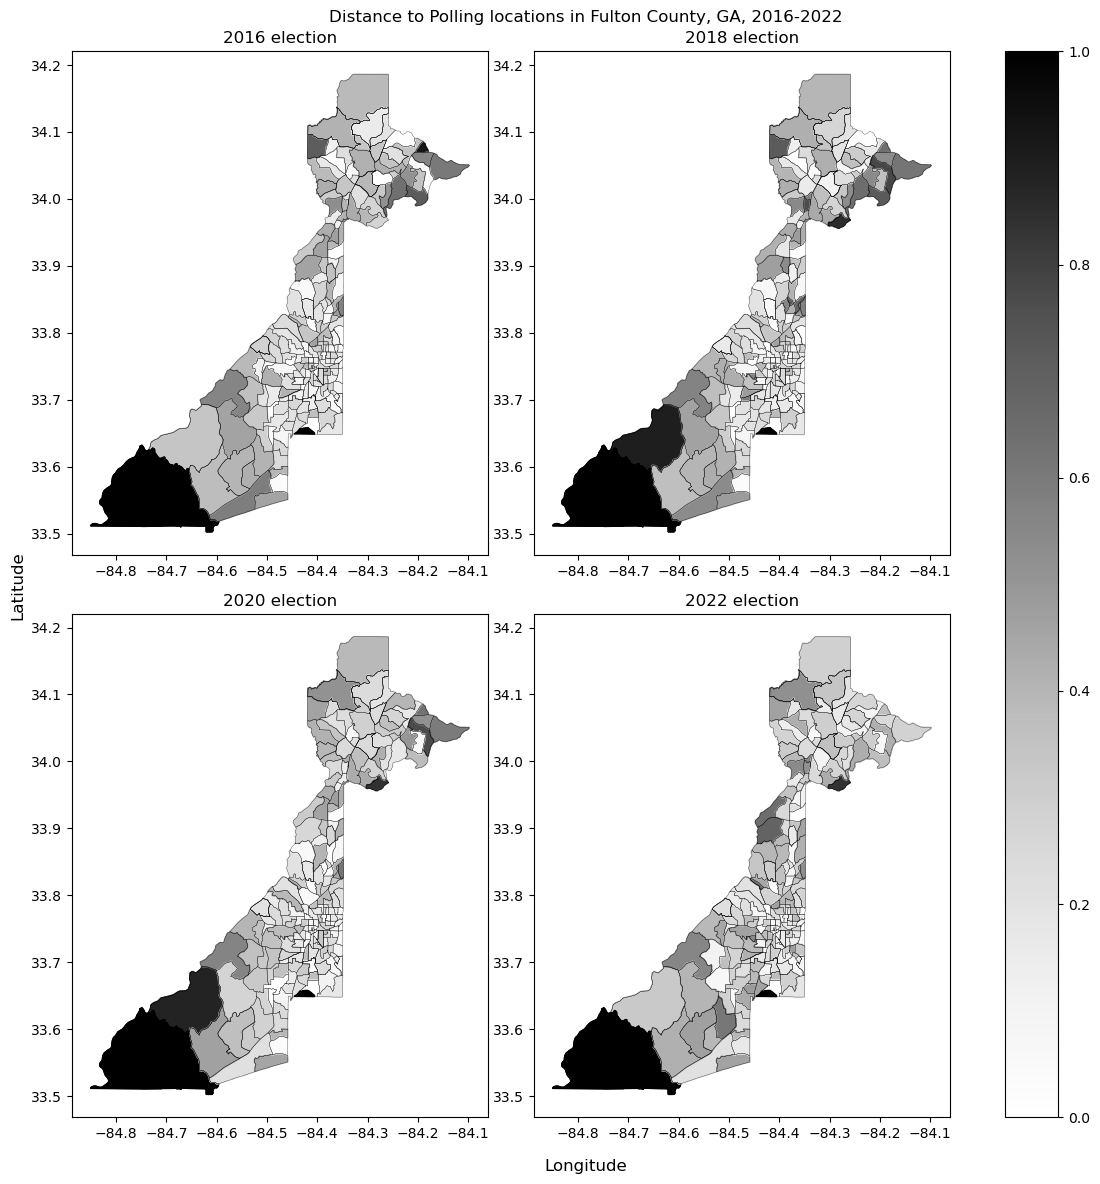

In [1134]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

# 2016 election data
for i in range(race_tracts_2016['geometry'].shape[0]):
    shape = race_tracts_2016['geometry'][i]
    x,y = shape.exterior.xy
    ax[0][0].plot(x,y,'black', linewidth=0.2)
    ax[0][1].plot(x,y,'black', linewidth=0.2)
    ax[1][0].plot(x,y,'black', linewidth=0.2)
    ax[1][1].plot(x,y,'black', linewidth=0.2)
    
    fill_color = temporary_df_2016['Total Distance per capita normalized'][i]
    if fill_color < 0:
        fill_color = 0
    ax[0][0].fill(x,y, color=(1-fill_color, \
                           1-fill_color, \
                           1-fill_color))

# 2018 election
for i in range(race_tracts_2018['geometry'].shape[0]):
    shape = race_tracts_2018['geometry'][i]
    x,y = shape.exterior.xy
    fill_color = temporary_df_2018['Total Distance per capita normalized'][i]
    if fill_color < 0:
        fill_color = 0
    ax[0][1].fill(x,y, color=(1-fill_color, \
                           1-fill_color, \
                           1-fill_color))
    
# 2020 election
for i in range(race_tracts['geometry'].shape[0]):
    shape = race_tracts['geometry'][i]
    x,y = shape.exterior.xy
    fill_color = temporary_df['Total Distance per capita normalized'][i]
    if fill_color < 0:
        fill_color = 0
    ax[1][0].fill(x,y, color=(1-fill_color, \
                           1-fill_color, \
                           1-fill_color))
    
# 2022 election
for i in range(race_tracts_2022['geometry'].shape[0]):
    shape = race_tracts_2022['geometry'][i]
    x,y = shape.exterior.xy
    fill_color = temporary_df_2022['Total Distance per capita normalized'][i]
    if fill_color < 0:
        fill_color = 0
    ax[1][1].fill(x,y, color=(1-fill_color, \
                           1-fill_color, \
                           1-fill_color))

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.02, hspace=0.02)

ax[0][0].set_title("2016 election")
ax[0][1].set_title("2018 election")
ax[1][0].set_title("2020 election")
ax[1][1].set_title("2022 election")
fig.suptitle("Distance to Polling locations in Fulton County, GA, 2016-2022")
fig.supxlabel("Longitude")
fig.supylabel("Latitude")
plt.tight_layout()
fig.canvas.draw()
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='Greys'), ax=list(ax.ravel()))
path = '/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/final_project/Polling_Locations/distance_results.png'
plt.savefig(path)
plt.show()

#### Now, doing this for all of Georgia

In [850]:
georgia_poll_site_distances = []
i=0
# while i < race_tracts.shape[0]:

# i=239
while i < race_tracts_2.shape[0]:
#     print(i)
    if i % 100 ==0:
        print(i)
    polygon = race_tracts_2['geometry'][i]
    population = race_tracts_2['population'][i]
    num_stations = int(race_tracts_2['Polling Station Count'][i])
    tract = race_tracts_2['Census Tract'][i]
    lat = []
    lon = []
    if num_stations > 1:
        for j in range(num_stations):
            lat.append(race_tracts_2['lat'][i+j])
            lon.append(race_tracts_2['lon'][i+j])
        i = i + num_stations - 1
    else:
        lat = [race_tracts_2['lat'][i]]
        lon = [race_tracts_2['lon'][i]]
    dist_to_poll = calculate_distance_to_poll(polygon, population, num_stations, lat, lon, race_tracts_2, tract)
    georgia_poll_site_distances.append([tract, dist_to_poll])
    i = i +1

georgia_distance_df = pd.DataFrame(np.array(georgia_poll_site_distances))
georgia_distance_df = georgia_distance_df.rename(columns={0:"Census Tract", 1: "Total Distance"})

0
100
200
300
600
700
800
900
1000
1200
1400
1500
1600
1700
1900
2000
2100
2200
2300


In [851]:
georgia_distance_df

Census Tract      Total Distance
0         Census Tract 401.01, Dade County  34.176754660346774
1         Census Tract 401.02, Dade County  4.3666066244531265
2            Census Tract 403, Dade County   70.75399774504965
3            Census Tract 402, Dade County    95.7028968942424
4     Census Tract 9101.03, Carroll County   82.52812889830764
...                                    ...                 ...
1964   Census Tract 6.02, Habersham County   61.53394062316394
1965      Census Tract 1, Habersham County  258.55779535952627
1966      Census Tract 5, Habersham County  10.145511351746407
1967      Census Tract 4, Habersham County    71.6330046094748
1968      Census Tract 3, Habersham County  108.00896535168867

[1969 rows x 2 columns]

In [891]:
state_df = race_tracts_2.merge(georgia_distance_df, how='left', on='Census Tract')
state_df['Normalized Total Distance'] = state_df['Total Distance'].astype(float) / np.max(state_df['Total Distance'].astype(float))
state_df['Total Distance per capita'] = state_df['Total Distance'].astype(float) / state_df['population'].astype(float)
max_distance_df = state_df.groupby('County')['Total Distance per capita'].max().to_frame().rename(columns={'Total Distance per capita': 'Max Distance per capita county'})
state_df = state_df.merge(max_distance_df, how='left', on='County')
state_df['Total Distance per capita normalized'] = state_df['Total Distance per capita'] / state_df['Max Distance per capita county']
# Using latitude of the center of Georgia b/c of geocoding issues at census tract level
state_df['Total Distance per capita km'] = state_df['Total Distance per capita'] * np.cos(33.247875/180*np.pi) * 111.11
state_df

Census Tract  \
0     Census Tract 401.01, Dade County   
1     Census Tract 401.01, Dade County   
2     Census Tract 401.02, Dade County   
3        Census Tract 403, Dade County   
4        Census Tract 402, Dade County   
...                                ...   
2325  Census Tract 1, Habersham County   
2326  Census Tract 5, Habersham County   
2327  Census Tract 4, Habersham County   
2328  Census Tract 4, Habersham County   
2329  Census Tract 3, Habersham County   

                                               geometry  population  Black  \
0     POLYGON ((-85.54631 34.86378, -85.54586 34.864...        2963     16   
1     POLYGON ((-85.54631 34.86378, -85.54586 34.864...        2963     16   
2     POLYGON ((-85.57449 34.81550, -85.57256 34.819...        2078      0   
3     POLYGON ((-85.54250 34.66244, -85.54187 34.663...        2881     30   
4     POLYGON ((-85.60495 34.98468, -85.60430 34.984...        2679     24   
...                                                 ...         ...    ...   
2325  POLYGON ((-83.49770 34.63777, -83.49771 34.638...        2276     27   
2326  POLYGON ((-83.59114 34.56958, -83.59100 34.569...        4517    192   
2327  POLYGON ((-83.52718 34.51109, -83.52650 34.511...        2901     25   
2328  POLYGON ((-83.52718 34.51109, -83.52650 34.511...        2901     25   
2329  POLYGON ((-83.55935 34.59274, -83.55924 34.592...        2750     99   

       % Black  Majority Black  Asian   % Asian  Majority Asian  White  ...  \
0     0.005400           False    122  0.041174           False   2781  ...   
1     0.005400           False    122  0.041174           False   2781  ...   
2     0.000000           False      0  0.000000           False   1965  ...   
3     0.010413           False     55  0.019091           False   2626  ...   
4     0.008959           False      0  0.000000           False   2489  ...   
...        ...             ...    ...       ...             ...    ...  ...   
2325  0.011863           False     13  0.005712           False   2136  ...   
2326  0.042506           False      9  0.001992           False   3684  ...   
2327  0.008618           False    182  0.062737           False   2158  ...   
2328  0.008618           False    182  0.062737           False   2158  ...   
2329  0.036000           False     15  0.005455           False   2275  ...   

            lon  Polling Station Count  Polling Station Count per capita  \
0    -85.510768                      2                          0.000675   
1    -85.419390                      2                          0.000675   
2    -85.536299                      1                          0.000481   
3           NaN                      0                          0.000000   
4           NaN                      0                          0.000000   
...         ...                    ...                               ...   
2325        NaN                      0                          0.000000   
2326 -83.548278                      1                          0.000221   
2327 -83.523160                      2                          0.000689   
2328 -83.491321                      2                          0.000689   
2329        NaN                      0                          0.000000   

      Polling Station Count per capita normalized      Total Distance  \
0                                        0.191698  34.176754660346774   
1                                        0.191698  34.176754660346774   
2                                        0.136670  4.3666066244531265   
3                                        0.000000   70.75399774504965   
4                                        0.000000    95.7028968942424   
...                                           ...                 ...   
2325                                     0.000000  258.55779535952627   
2326                                     0.062874  10.145511351746407   
2327                                     0.195795    71.633004609

In [892]:
coords2 = coords2.drop_duplicates()

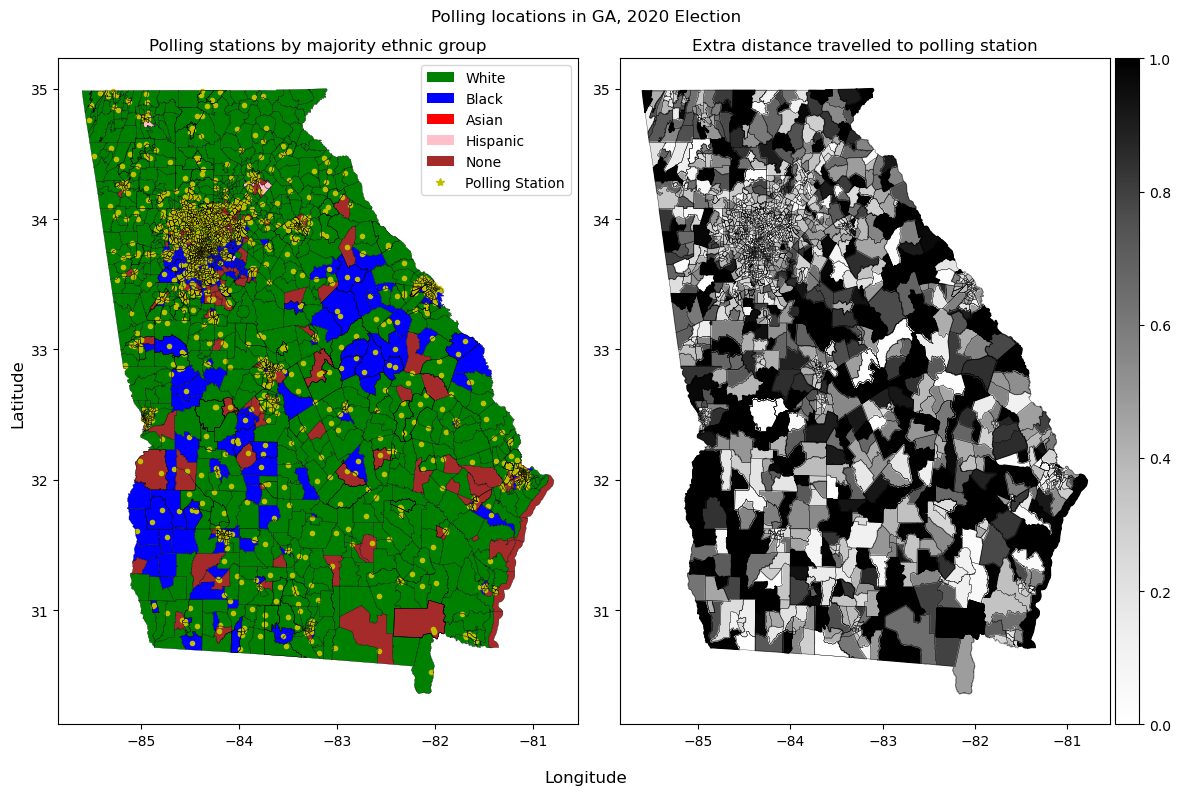

In [1135]:
xmin, ymin, xmax, ymax = georgia[georgia['NAME']=='Fulton']['geometry'].total_bounds
fig, ax = plt.subplots(1,2, figsize=(12,8))

# Plotting polling station locations in Fulton county
for index in coords2.index:
    ax[0].plot(float(coords2.loc[index, :]['lon']), float(coords2.loc[index, :]['lat']),"y.")

for i in range(state_df['geometry'].shape[0]):
    try:
        shape = state_df['geometry'][i]
        x,y = shape.exterior.xy
        ax[0].plot(x,y,'black', linewidth=0.2)
        
        # I can fill based on different values
        if state_df['Majority White'][i]==True:
            ax[0].fill(x,y, 'green')
        elif state_df['Majority Black'][i]==True:
            ax[0].fill(x,y, 'blue')
        elif state_df['Majority Asian'][i]==True:
            ax[0].fill(x,y, 'red')
        elif state_df['Majority Hispanic'][i]==True:
            ax[0].fill(x,y, 'pink')
        else:
            ax[0].fill(x,y, 'brown')
        ax[1].plot(x,y,'black', linewidth=0.2)
        fill_color = state_df['Total Distance per capita normalized'][i]
        if fill_color < 0:
            fill_color = 0
        ax[1].fill(x,y, color=(1-fill_color, \
                               1-fill_color, \
                               1-fill_color))
    except Exception as e:
        for poly in shape.geoms:
            x,y = poly.exterior.xy
            ax[0].plot(x,y,'black', linewidth=0.2)
            # I can fill based on different values
            if state_df['Majority White'][i]==True:
                ax[0].fill(x,y, 'green')
            elif state_df['Majority Black'][i]==True:
                ax[0].fill(x,y, 'blue')
            elif state_df['Majority Asian'][i]==True:
                ax[0].fill(x,y, 'red')
            elif state_df['Majority Hispanic'][i]==True:
                ax[0].fill(x,y, 'pink')
            else:
                ax[0].fill(x,y, 'brown')
            ax[1].plot(x,y,'black', linewidth=0.2)
            fill_color = state_df['Total Distance per capita normalized'][i]
            if fill_color < 0:
                fill_color = 0
            ax[1].fill(x,y, color=(1-fill_color, \
                                   1-fill_color, \
                                   1-fill_color))
  
ax[0].fill([], 'green', label='White')
ax[0].fill([], 'blue', label='Black')
ax[0].fill([], 'red', label='Asian')
ax[0].fill([], 'pink', label='Hispanic')
ax[0].fill([], 'brown', label='None')
ax[0].plot([], 'y*', label='Polling Station')
ax[0].set_title("Polling stations by majority ethnic group")
ax[0].legend(loc='upper right')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)

ax[1].set_title("Extra distance travelled to polling station")
fig.suptitle("Polling locations in GA, 2020 Election")
fig.supxlabel("Longitude")
fig.supylabel("Latitude")

plt.colorbar(plt.cm.ScalarMappable(cmap='Greys'), cax=cax)
plt.tight_layout()
path = '/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/final_project/Polling_Locations/georgia_results.png'
plt.savefig(path)
plt.show()

/var/folders/5w/82q2gcks59d3npvwjk0xmsm80000gn/T/ipykernel_85600/846059477.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([0,1,2,3,4,5])


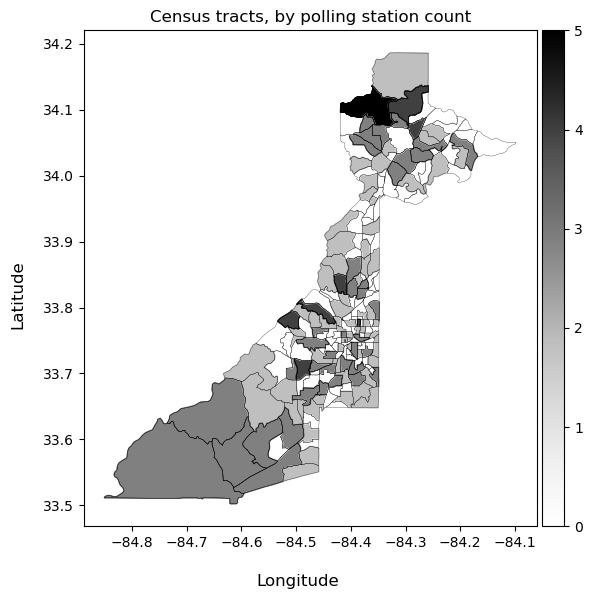

In [1152]:
xmin, ymin, xmax, ymax = georgia[georgia['NAME']=='Fulton']['geometry'].total_bounds
fig, ax = plt.subplots(1,1, figsize=(6,6))

station_counts = race_tracts['Polling Station Count'] / np.max(race_tracts['Polling Station Count'])
    
for i in range(race_tracts['geometry'].shape[0]):
    shape = race_tracts['geometry'][i]
    x,y = shape.exterior.xy
    ax.plot(x,y,'black', linewidth=0.2)
    ax.fill(x,y, color=(1-station_counts[i],1-station_counts[i],1-station_counts[i]))

ax.set_title("Census tracts, by polling station count")
fig.supxlabel("Longitude")
fig.supylabel("Latitude")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Greys'), cax=cax)
# cbar.set_ticks([0.0, 1.0, 2.0, 3.0])
cbar.set_ticklabels([0,1,2,3,4,5])
plt.tight_layout()
path = '/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/final_project/Polling_Locations/fulton_station_count.png'
plt.savefig(path)
plt.show()

In [1156]:
race_tracts['Polling Station Count'].value_counts()

0.0    92
2.0    76
1.0    66
3.0    21
4.0     4
Name: Polling Station Count, dtype: int64

In [1187]:
results_df = (111.11*temporary_df_2016['Total Distance per capita'].astype(float)*np.cos(temporary_df_2016['lat'].astype(float) / 180*np.pi))\
.sort_values(ascending=False).to_frame()
results_df['2018'] = (111.11*temporary_df_2018['Total Distance per capita'].astype(float)*np.cos(temporary_df_2018['lat'].astype(float) / 180*np.pi))\
.sort_values(ascending=False).to_frame()
results_df['2020'] = (111.11*temporary_df['Total Distance per capita'].astype(float)*np.cos(temporary_df['lat'].astype(float) / 180*np.pi))\
.sort_values(ascending=False).to_frame()
results_df['2022'] = (111.11*temporary_df_2022['Total Distance per capita'].astype(float)*np.cos(temporary_df_2022['lat'].astype(float) / 180*np.pi))\
.sort_values(ascending=False).to_frame()
# results_df['']
results_df['2020'].std()

0.5103212040880936

In [1191]:
print(temporary_df_2016[temporary_df_2016['Majority Black']==True]['Total Distance per capita km'].max())
print(temporary_df_2016[temporary_df_2016['Majority White']==True]['Total Distance per capita km'].max())

3.5823623749872895
1.1402651437696827


In [1190]:
print(temporary_df_2018[temporary_df_2018['Majority Black']==True]['Total Distance per capita km'].max())
print(temporary_df_2018[temporary_df_2018['Majority White']==True]['Total Distance per capita km'].max())

3.5115088579909255
1.105773262856198


In [1188]:
print(temporary_df[temporary_df['Majority Black']==True]['Total Distance per capita km'].max())
print(temporary_df[temporary_df['Majority White']==True]['Total Distance per capita km'].max())

3.5629911522441473
1.5162744684118956


In [1192]:
print(temporary_df_2022[temporary_df_2022['Majority Black']==True]['Total Distance per capita km'].max())
print(temporary_df_2022[temporary_df_2022['Majority White']==True]['Total Distance per capita km'].max())

3.5715703783457062
1.5430705279684696


In [1194]:
print(temporary_df_2016[temporary_df_2016['Majority Black']==True]['Total Distance per capita km'].mean())
print(temporary_df_2016[temporary_df_2016['Majority White']==True]['Total Distance per capita km'].mean())

0.4078638113013641
0.3741115890945458


In [1193]:
print(temporary_df_2018[temporary_df_2018['Majority Black']==True]['Total Distance per capita km'].mean())
print(temporary_df_2018[temporary_df_2018['Majority White']==True]['Total Distance per capita km'].mean())

0.4184286524855046
0.31013721782689274


In [147]:
print(temporary_df[temporary_df['Majority Black']==True]['Total Distance per capita km'].mean())
print(temporary_df[temporary_df['Majority White']==True]['Total Distance per capita km'].mean())

print(temporary_df[temporary_df['Majority Black']==True]['Total Distance per capita km'].mean() - \
     temporary_df[temporary_df['Majority White']==True]['Total Distance per capita km'].mean())

0.4504539388844599
0.37740122187553554
0.07305271700892435


In [1195]:
print(temporary_df_2022[temporary_df_2022['Majority Black']==True]['Total Distance per capita km'].mean())
print(temporary_df_2022[temporary_df_2022['Majority White']==True]['Total Distance per capita km'].mean())

0.4658241815888395
0.39661314263958886


In [ ]:
print(temporary_df[temporary_df['Majority Black']==True]['Total Distance per capita km'].max())
print(temporary_df[temporary_df['Majority White']==True]['Total Distance per capita km'].max())

print(temporary_df[temporary_df['Majority Black']==True]['Total Distance per capita km'].std())
print(temporary_df[temporary_df['Majority White']==True]['Total Distance per capita km'].std())

print(temporary_df[temporary_df['Majority Black']==True]['Total Distance per capita km'].mean())
print(temporary_df[temporary_df['Majority White']==True]['Total Distance per capita km'].mean())

print(temporary_df[temporary_df['Majority Black']==True]['Total Distance per capita km'].mean() - \
     temporary_df[temporary_df['Majority White']==True]['Total Distance per capita km'].mean())

# Appendix

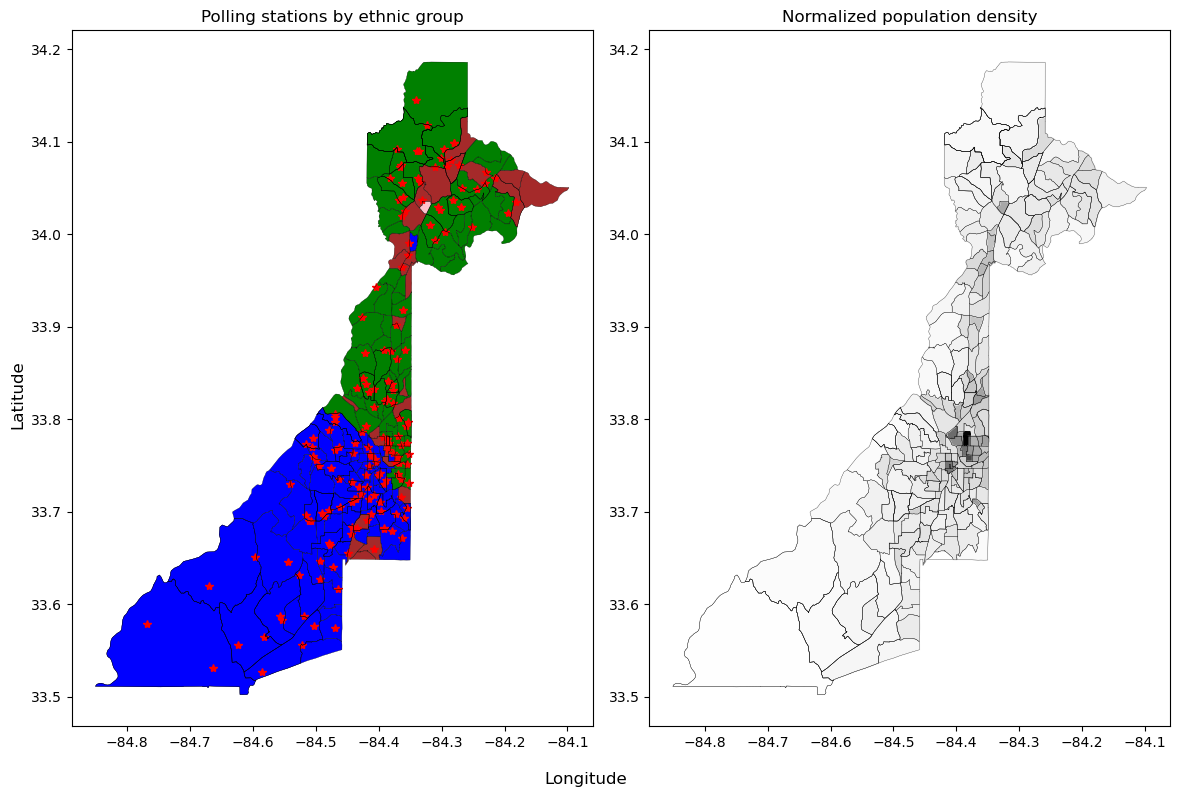

In [116]:
xmin, ymin, xmax, ymax = georgia[georgia['NAME']=='Fulton']['geometry'].total_bounds
fig, ax = plt.subplots(1,2, figsize=(12,8))

# Plotting polling station locations in Fulton county
for index in coords.index:
    point = Point(float(coords.loc[index, :]['lon']), float(coords.loc[index, :]['lat']))
    if georgia[georgia['NAME']=='Fulton']['geometry'].contains(point).values[0]:
        ax[0].plot(float(coords.loc[index, :]['lon']), float(coords.loc[index, :]['lat']),"r*")
    
for i in range(race_tracts['geometry'].shape[0]):
    shape = race_tracts['geometry'][i]
    x,y = shape.exterior.xy
    ax[0].plot(x,y,'black', linewidth=0.2)
    
    # I can fill based on different values
    if race_tracts['Majority White'][i]:
        ax[0].fill(x,y, 'green')
    elif race_tracts['Majority Black'][i]:
        ax[0].fill(x,y, 'blue')
    elif race_tracts['Majority Asian'][i]:
        ax[0].fill(x,y, 'orange')
    elif race_tracts['Majority Hispanic'][i]:
        ax[0].fill(x,y, 'pink')
    else:
        ax[0].fill(x,y, 'brown')
        
    ax[1].plot(x,y,'black', linewidth=0.2)
    # The darker the color, the more concentrated the (normalized) population density
    ax[1].fill(x,y, color=(1-race_tracts['normalized_pop'][i],1-race_tracts['normalized_pop'][i], 1-race_tracts['normalized_pop'][i]))

ax[0].set_title("Polling stations by ethnic group")
ax[1].set_title("Normalized population density")
# fig.suptitle("Test")
fig.supxlabel("Longitude")
fig.supylabel("Latitude")

plt.tight_layout()
plt.show()

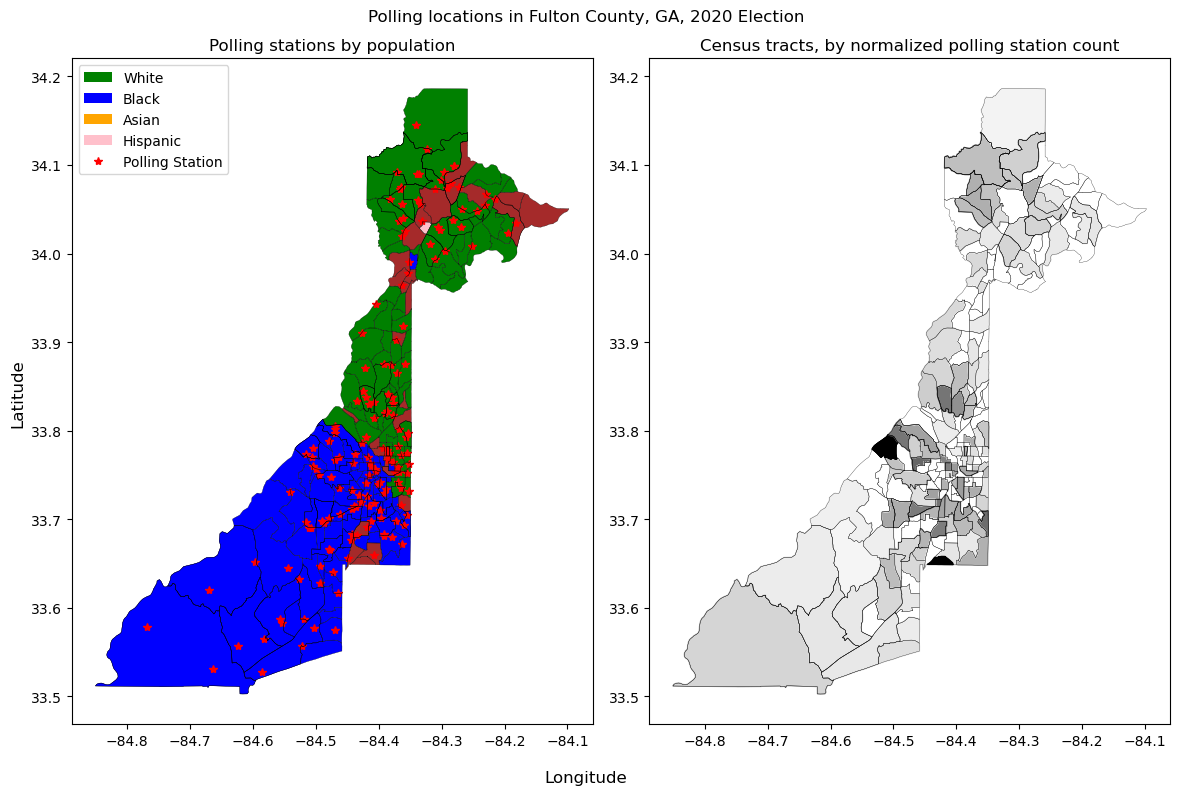

In [118]:
xmin, ymin, xmax, ymax = georgia[georgia['NAME']=='Fulton']['geometry'].total_bounds
fig, ax = plt.subplots(1,2, figsize=(12,8))

# Plotting polling station locations in Fulton county
for index in coords.index:
    point = Point(float(coords.loc[index, :]['lon']), float(coords.loc[index, :]['lat']))
    if georgia[georgia['NAME']=='Fulton']['geometry'].contains(point).values[0]:
        ax[0].plot(float(coords.loc[index, :]['lon']), float(coords.loc[index, :]['lat']),"r*")


station_counts = race_tracts['Polling Station Count'] / np.max(race_tracts['Polling Station Count'])
    
for i in range(race_tracts['geometry'].shape[0]):
    shape = race_tracts['geometry'][i]
    x,y = shape.exterior.xy
    ax[0].plot(x,y,'black', linewidth=0.2)
        
    # I can fill based on different values
    if race_tracts['Majority White'][i]:
        ax[0].fill(x,y, 'green')
    elif race_tracts['Majority Black'][i]:
        ax[0].fill(x,y, 'blue')
    elif race_tracts['Majority Asian'][i]:
        ax[0].fill(x,y, 'orange')
    elif race_tracts['Majority Hispanic'][i]:
        ax[0].fill(x,y, 'pink')
    else:
        ax[0].fill(x,y, 'brown')
    ax[1].plot(x,y,'black', linewidth=0.2)
    ax[1].fill(x,y, color=(1-race_tracts['Polling Station Count per capita normalized'][i], \
                           1-race_tracts['Polling Station Count per capita normalized'][i], \
                           1-race_tracts['Polling Station Count per capita normalized'][i]))

    
ax[0].fill([], 'green', label='White')
ax[0].fill([], 'blue', label='Black')
ax[0].fill([], 'orange', label='Asian')
ax[0].fill([], 'pink', label='Hispanic')
ax[0].plot([], 'r*', label='Polling Station')
ax[0].set_title("Polling stations by population")
ax[0].legend()

ax[1].set_title("Census tracts, by normalized polling station count")
fig.suptitle("Polling locations in Fulton County, GA, 2020 Election")
fig.supxlabel("Longitude")
fig.supylabel("Latitude")
    
plt.tight_layout()
plt.show()

# TRASH BIN

(-84.4260789998494, 33.76343300022594, -84.40880800005523, 33.773217999804494)


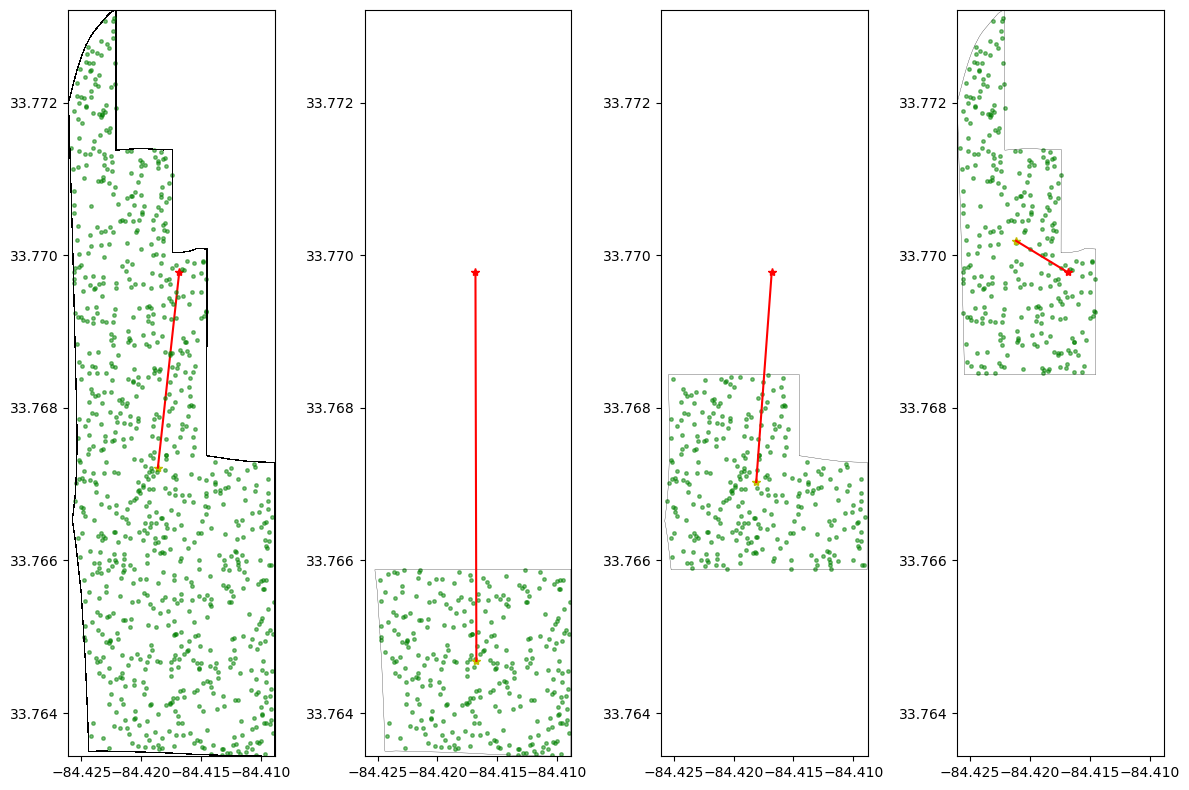

In [2060]:
fig, ax = plt.subplots(1,num_polys+1, figsize=(12,8))
min_x, min_y, max_x, max_y = poly.bounds
lat = float(race_tracts.iloc[0]['lat'])
lon = float(race_tracts.iloc[0]['lon'])
ax[0].plot(lon, lat, 'r*')
x,y = poly.centroid.xy
ax[0].plot(x[0], y[0], 'y*')
ax[0].plot([lon, x[0]], [lat, y[0]], color='r')

for i in range(len(random_points.geoms)):
    x,y = random_points.geoms[i].xy
    ax[0].plot(x,y,'g.', alpha=0.5, markersize=5)
    x1, y1 = poly.exterior.xy
    ax[0].plot(x1,y1,'black', linewidth=0.2)
    
for i in range(num_polys):
    random_points_slice = points_chunks[i]
    for j in range(len(random_points_slice.geoms)):
        x,y = random_points_slice.geoms[j].xy
        ax[i+1].plot(x,y,'g.', alpha=0.5, markersize=5)
    
    # Plotting each sub-polygon exterior
    x,y = polys[i].exterior.xy
    ax[i+1].plot(x,y,'black', linewidth=0.2)
    
    # Plotting actual polling location
    ax[i+1].plot(lon, lat, 'r*')
    
    # Plotting sub-polygon centroid
    c_x,c_y = polys[i].centroid.xy
    ax[i+1].plot(c_x,c_y,'y*')
    ax[i+1].plot([lon, c_x[0]], [lat, c_y[0]], color='r')
            
for i in range(len(ax)):
    ax[i].set_xlim(min_x, max_x)
    ax[i].set_ylim(min_y, max_y)
    
plt.tight_layout();

0.0 297.0
---------
297.0 594.0
---------
594.0 891.0
---------


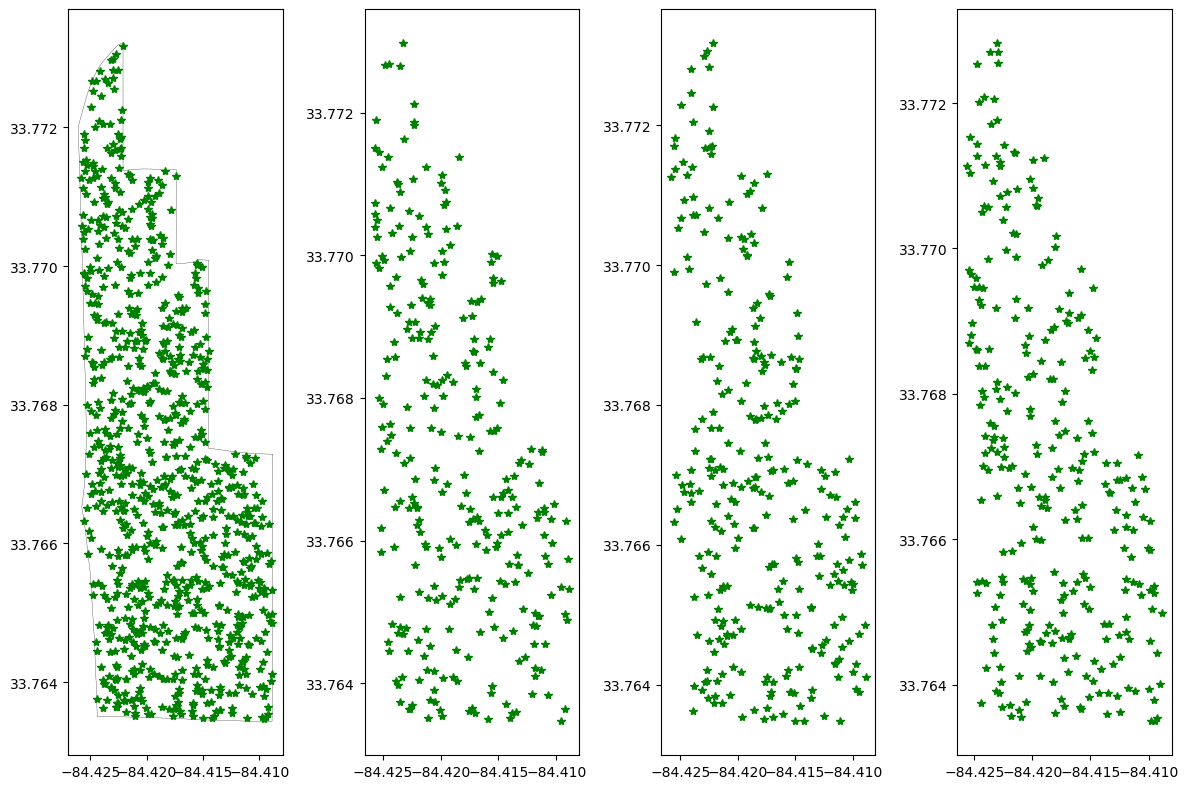

In [1418]:
num_polys = 3

fig, ax = plt.subplots(1,num_polys+1, figsize=(12,8))

# Plotting full polygon
poly = race_tracts['geometry'][0]
poll_x, poll_y = race_tracts['geometry'][0].exterior.xy
ax[0].plot(poll_x, poll_y, 'black', linewidth=0.2)


for i in range(len(random_points)):
    x,y = random_points[i].xy
    ax[0].plot(x,y,'g*')


random_points = random_points_within(poly, pop)   
min_x, min_y, max_x, max_y = poly.bounds
# for i in range(num_polys):
    

line = LineString([(min_x, min_y),(max_x, max_y)])
polys = list(shp.ops.split(poly, line).geoms)
    
# for i in range(num_polys):
#     print(i*pop/num_polys, (i+1)*pop/num_polys)
#     start = int(i*pop/num_polys)
#     end = int((i+1)*pop/num_polys)
#     random_points_slice = random_points[start:end]
#     for j in range(len(random_points_slice)):
#         x,y = random_points_slice[j].xy
#         ax[i+1].plot(x,y,'g*')
#     print(random_points[start:end])
#     print("---------")
#     print(len(random_points[(i*(pop/num_polys)): (i+1*(pop/num_polys))]))
    
#     for j in range(pop):
        
    
    
plt.tight_layout();
    
    
        

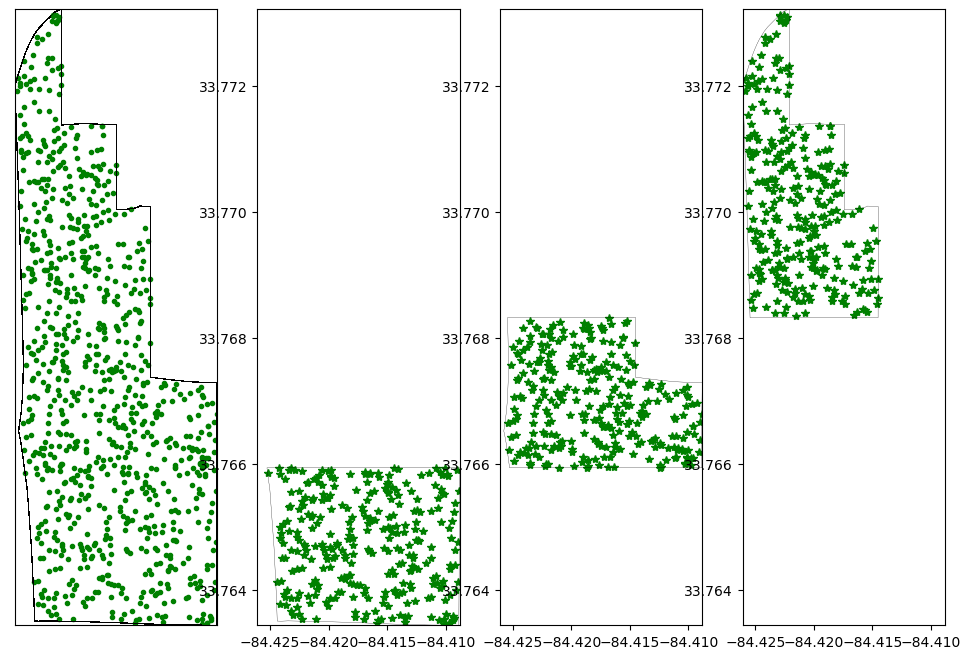

In [1762]:
poly = race_tracts.iloc[0]['geometry']
pop = race_tracts.iloc[0]['population']
random_points = random_points_within(poly, pop, 1)

# Split into two
# for i in range(len(random_points.geoms)):
#     x,y = random_points.geoms[i].xy
#     if i < len(random_points.geoms)/2:
#         plt.plot(x,y, 'b.')
#     else:
#         plt.plot(x,y, 'g.')
        
        
# Split into three
num_polys = 3
fig, ax = plt.subplots(1,num_polys+1, figsize=(12,8))

min_x, min_y, max_x, max_y = poly.bounds

lat = race_tracts.iloc[0]['lon']
lon = race_tracts.iloc[0]['lon']
ax[0].plot(lon, lat, 'r*')

for i in range(len(random_points.geoms)):
    x,y = random_points.geoms[i].xy
    ax[0].plot(x,y,'g.')
    x1, y1 = poly.exterior.xy
    ax[0].plot(x1,y1,'black', linewidth=0.2)
    


slices = []
    

for i in range(num_polys):   
    start = int(i*pop/num_polys)
    end = int((i+1)*pop/num_polys)
    random_points_slice = random_points.geoms[start:end]
    slice_min_x, slice_min_y, slice_max_x, slice_max_y = random_points_slice.bounds
    slices.append(slice_max_y)
    bottom_line = LineString([(slice_min_x, slice_min_y),(slice_max_x, slice_min_y)])
    top_line = LineString([(slice_min_x, slice_max_y),(slice_max_x, slice_max_y)])
#     line = MultiLineString([bottom_line, top_line])
    polys = list(shp.ops.split(poly, top_line).geoms)
    for j in range(len(random_points_slice.geoms)):
        x,y = random_points_slice.geoms[j].xy
        ax[i+1].plot(x,y,'g*')

        
polys = split_polygon(poly, slices)

for i in range(num_polys):
    x,y = polys[i].exterior.xy
    ax[i+1].plot(x,y,'black', linewidth=0.2)
        
#         x1, y1 = polys[0].exterior.xy
#         ax[i+1].plot(x1, y1, 'black', linewidth=0.2)

# for i in range(len(test.geoms)):
#     x,y = test.geoms[i].xy
#     if i < len(random_points.geoms)/2:
#         plt.plot(x,y, 'g.')
#     else:
#         plt.plot(x,y, 'b.')

for i in range(len(ax)):
    ax[i].set_xlim(min_x, max_x)
    ax[i].set_ylim(min_y, max_y)

-84.41867714279475 33.76722718373599


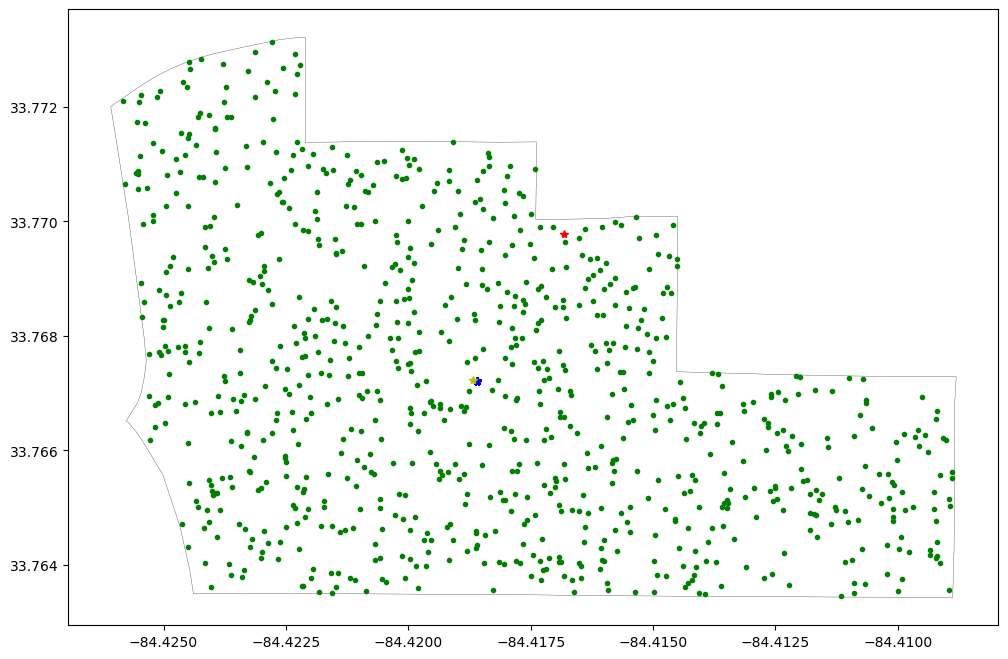

In [1353]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

poll_x, poll_y = race_tracts['geometry'][0].exterior.xy
ax.plot(poll_x, poll_y, 'black', linewidth=0.2)

# Plotting polling station location
lat = float(test['lat'][0])
lon = float(test['lon'][0])
ax.plot(lon, lat, 'r*')

distances = np.zeros(pop)

poly = race_tracts.iloc[0]['geometry'] # Would want to update this to index for eventual for loop
pop = race_tracts.iloc[0]['population']
random_points = random_points_within(poly, pop)
for i in range(len(random_points)):
    x, y = random_points[i].xy
    distance = calculate_distance(x[0], y[0], lon, lat)
    distances[i] = distance
    ax.plot(x,y, 'g.')
    x_1, y_1 = poly.centroid.xy
    ax.plot(x_1, y_1, "b*")
    
opt_lon, opt_lat = find_optimal_location(poly, pop, random_points, 50)
ax.plot(opt_lon, opt_lat, 'y*')

33.76557338940566 33.76343300022594
2
0
Appending step
(-84.4260789998494, 33.76343300022594, -84.40880800005523, 33.773217999804494)
(-84.4260789998494, 33.76557338940566, -84.40880800005523, 33.773217999804494)
33.76822630613067 33.76557338940566
2
1
Appending last


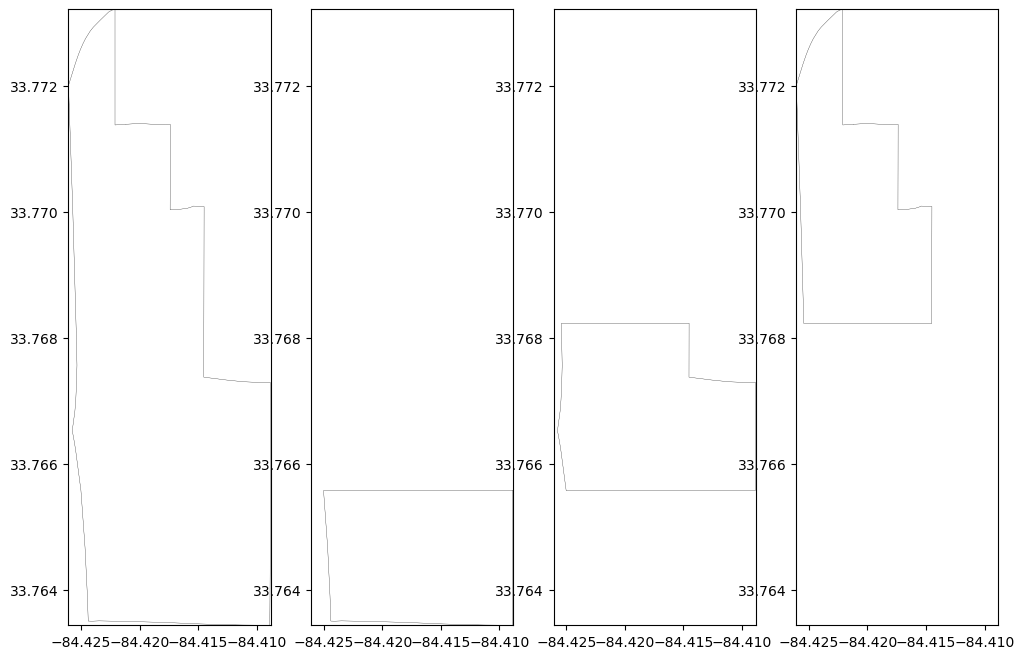

In [1675]:
poly = race_tracts.iloc[0]['geometry']
num_splits=len(slices)
polys = split_polygon(poly, slices)
fig, ax = plt.subplots(1,num_splits+1,figsize=(12,8))

x,y = poly.exterior.xy
ax[0].plot(x,y,'black', linewidth=0.2)

for i in range(num_splits):
    x,y = polys[i].exterior.xy
    ax[i+1].plot(x,y,'black', linewidth=0.2)

    
min_x, min_y, max_x, max_y = poly.bounds
    
for i in range(len(ax)):
    ax[i].set_xlim(min_x, max_x)
    ax[i].set_ylim(min_y, max_y)

33.76343300022594 33.768325500015216 33.773217999804494


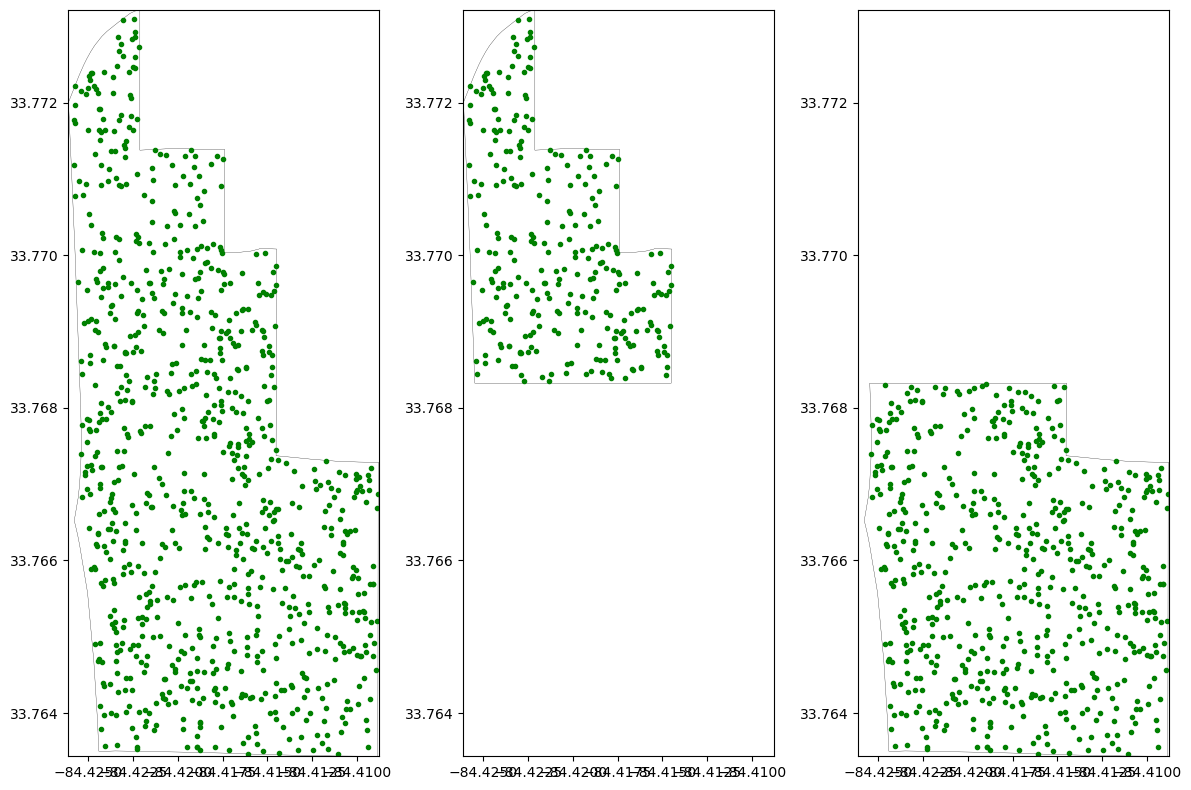

In [1421]:
# I THINK I CAN DELETE THIS
fig, ax = plt.subplots(1,3, figsize=(12,8))

# Plotting full polygon
poly = race_tracts['geometry'][0]
poll_x, poll_y = race_tracts['geometry'][0].exterior.xy
ax[0].plot(poll_x, poll_y, 'black', linewidth=0.2)

# Dividing polygon into two
min_x, min_y, max_x, max_y = poly.bounds
# line = LineString([(min_x, min_y),(max_x, max_y)])
half_y = (max_y - min_y)/2 + min_y
print(min_y, half_y, max_y)
line = LineString([(min_x, half_y),(max_x, half_y)])
polys = list(shp.ops.split(poly, line).geoms)

# Plotting first split poly
x1, y1 = polys[0].exterior.xy
ax[1].plot(x1, y1, 'black', linewidth=0.2)

# Plotting second split poly
x2, y2 = polys[1].exterior.xy
ax[2].plot(x2,y2, 'black', linewidth=0.2)


# Creating arrays for random points divided between the two split polygons
random_points = random_points_within(poly, pop)
random_points_1 = []
random_points_2 = []
for i in range(len(random_points)):
    x,y = random_points[i].xy
    ax[0].plot(x,y,'g.')
    if polys[0].contains(random_points[i]):
        ax[1].plot(x,y,'g.')
        random_points_1.append(random_points[i])
    else:
        ax[2].plot(x,y,'g.')
        random_points_2.append(random_points[i])
        
        
# Ensuring x and y limits are the same for each plot
for i in range(len(ax)):
    ax[i].set_xlim(min_x, max_x)
    ax[i].set_ylim(min_y, max_y)


plt.tight_layout();

In [1349]:
# I think I can delete this function

def find_optimal_location(poly, pop, random_points, num_test_stations):
    # Setting up variables, arrays
    min_x, min_y, max_x, max_y = poly.bounds
    x_range = np.linspace(min_x, max_x, num=num_test_stations)
    y_range = np.linspace(min_y, max_y, num=num_test_stations)
    locations = np.zeros((num_test_stations, num_test_stations))

    
    for i in range(len(x_range)):
        for j in range(len(y_range)):
            distances = np.zeros(pop)
            for k in range(len(random_points)):
                x, y = random_points[k].xy
                distance = calculate_distance(x[0], y[0], x_range[i], y_range[j])
                distances[k] = distance
            locations[i][j] = np.sum(distances)

    lon = int(np.round(np.argmin(locations)/num_test_stations))
    lat = np.argmin(locations) % num_test_stations
#     print(x_range[lon], y_range[lat])
    
    return x_range[lon], y_range[lat]